# Бейзлайн для распознавания автомобильных номеров. 

MADE with love :)

In [1]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

import webp

In [2]:
torch.__version__, torch.cuda.is_available()

('1.4.0', True)

### Сейчас будет много вспомогательных функций, которые можно промотать

Чтобы было наглядно и не приходилось лезть в модули, чтобы посмотреть, какая функция что делает, оставил для наглядности пока что все в ноутбуке. Можно аккуратно перенести в модули :)

In [3]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = my_transforms(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            # contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            _,contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [4]:
DATA_PATH = './data/'
TRAIN_SIZE = 0.87
BATCH_SIZE = 2
BATCH_SIZE_OCR = 16
DETECTOR_MODEL_PATH = 'detector.pt'
OCR_MODEL_PATH = 'ocr.pt'

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 1. Находим номера

### a) Модель для детекции

В задании есть данные о 4 точках, которые задают номер. Эти 4 точки - почти всегда не прямоугольник, а произвольный четырехугольник. Будем предсказывать:

- bounding box, который окружает точки (детекция)
- маску, заполненную тем, что внутри 4-х точек (сегментация)

Поэтому, возьмем maskrcnn. Будем обучать несколько последних солев. Этого с запасом хватает.

In [5]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

### b) Датасет для детекции

In [6]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='data/', 
    transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='data/', 
    transforms=my_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn, 
)

### c) Обучаем модель для детекции

In [7]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
# model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device);

Валидироваться на чем-то нет смысла, ибо лосс перестает падать еще до того момента, как пройдет 1-я эпоха. Т.е. лосс на трейне вполне валидный, ибо модель видит данные в первый раз.

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

  0%|          | 20/11150 [00:15<1:58:19,  1.57it/s]

Loss: 0.9889933


  0%|          | 40/11150 [00:26<1:45:07,  1.76it/s]

Loss: 0.5644188


  1%|          | 60/11150 [00:37<1:43:07,  1.79it/s]

Loss: 0.3946894


  1%|          | 80/11150 [00:48<1:32:04,  2.00it/s]

Loss: 0.3189397


  1%|          | 100/11150 [00:58<1:32:17,  2.00it/s]

Loss: 0.3034507


  1%|          | 120/11150 [01:08<1:33:48,  1.96it/s]

Loss: 0.2460861


  1%|▏         | 140/11150 [01:20<1:39:10,  1.85it/s]

Loss: 0.2494154


  1%|▏         | 160/11150 [01:30<1:42:09,  1.79it/s]

Loss: 0.2311998


  2%|▏         | 180/11150 [01:41<1:37:32,  1.87it/s]

Loss: 0.2618450


  2%|▏         | 200/11150 [01:51<1:33:28,  1.95it/s]

Loss: 0.2442906


  2%|▏         | 220/11150 [02:02<1:49:42,  1.66it/s]

Loss: 0.1781886


  2%|▏         | 240/11150 [02:14<1:41:31,  1.79it/s]

Loss: 0.2063275


  2%|▏         | 260/11150 [02:24<1:32:52,  1.95it/s]

Loss: 0.2154516


  3%|▎         | 280/11150 [02:36<2:00:08,  1.51it/s]

Loss: 0.2112359


  3%|▎         | 300/11150 [02:48<1:48:39,  1.66it/s]

Loss: 0.1800098


  3%|▎         | 320/11150 [02:58<1:29:46,  2.01it/s]

Loss: 0.1953431


  3%|▎         | 340/11150 [03:09<1:40:55,  1.79it/s]

Loss: 0.2078635


  3%|▎         | 360/11150 [03:20<1:36:46,  1.86it/s]

Loss: 0.1955260


  3%|▎         | 380/11150 [03:32<1:47:33,  1.67it/s]

Loss: 0.1846722


  4%|▎         | 400/11150 [03:43<1:38:38,  1.82it/s]

Loss: 0.1810523


  4%|▍         | 420/11150 [03:54<1:33:13,  1.92it/s]

Loss: 0.1989894


  4%|▍         | 440/11150 [04:04<1:31:15,  1.96it/s]

Loss: 0.1922454


  4%|▍         | 460/11150 [04:15<1:40:37,  1.77it/s]

Loss: 0.1805424


  4%|▍         | 480/11150 [04:25<1:32:10,  1.93it/s]

Loss: 0.2492720


  4%|▍         | 500/11150 [04:36<1:36:27,  1.84it/s]

Loss: 0.1958868


  5%|▍         | 520/11150 [04:48<1:46:23,  1.67it/s]

Loss: 0.2232659


  5%|▍         | 540/11150 [04:59<1:39:24,  1.78it/s]

Loss: 0.2052701


  5%|▌         | 560/11150 [05:11<1:37:54,  1.80it/s]

Loss: 0.1985046


  5%|▌         | 580/11150 [05:25<2:22:53,  1.23it/s]

Loss: 0.2212425


  5%|▌         | 600/11150 [05:39<1:42:59,  1.71it/s]

Loss: 0.1993470


  6%|▌         | 620/11150 [05:49<1:30:00,  1.95it/s]

Loss: 0.2081565


  6%|▌         | 640/11150 [06:00<1:28:38,  1.98it/s]

Loss: 0.2121509
Epoch    32: reducing learning rate of group 0 to 1.5000e-04.


  6%|▌         | 660/11150 [06:11<1:41:22,  1.72it/s]

Loss: 0.1877574


  6%|▌         | 680/11150 [06:23<1:44:28,  1.67it/s]

Loss: 0.1752341


  6%|▋         | 700/11150 [06:35<1:50:41,  1.57it/s]

Loss: 0.1734766


  6%|▋         | 720/11150 [06:46<1:45:01,  1.66it/s]

Loss: 0.1472636


  7%|▋         | 740/11150 [06:59<1:38:57,  1.75it/s]

Loss: 0.1770599


  7%|▋         | 760/11150 [07:10<1:37:34,  1.77it/s]

Loss: 0.1992683


  7%|▋         | 780/11150 [07:20<1:29:30,  1.93it/s]

Loss: 0.1716879


  7%|▋         | 800/11150 [07:32<1:43:23,  1.67it/s]

Loss: 0.1865919


  7%|▋         | 820/11150 [07:43<1:30:57,  1.89it/s]

Loss: 0.1841801


  8%|▊         | 840/11150 [07:54<1:32:41,  1.85it/s]

Loss: 0.1867645


  8%|▊         | 860/11150 [08:05<1:29:07,  1.92it/s]

Loss: 0.1682763


  8%|▊         | 880/11150 [08:16<1:31:33,  1.87it/s]

Loss: 0.1793811


  8%|▊         | 900/11150 [08:27<1:26:07,  1.98it/s]

Loss: 0.1427965


  8%|▊         | 920/11150 [08:38<1:31:47,  1.86it/s]

Loss: 0.1808510


  8%|▊         | 940/11150 [08:49<1:48:46,  1.56it/s]

Loss: 0.1842233


  9%|▊         | 960/11150 [09:00<1:32:17,  1.84it/s]

Loss: 0.1768320


  9%|▉         | 980/11150 [09:12<1:32:13,  1.84it/s]

Loss: 0.1708871


  9%|▉         | 1000/11150 [09:24<1:45:08,  1.61it/s]

Loss: 0.1551013


  9%|▉         | 1020/11150 [09:36<1:38:32,  1.71it/s]

Loss: 0.1791782


  9%|▉         | 1040/11150 [09:49<1:39:05,  1.70it/s]

Loss: 0.1785187


 10%|▉         | 1060/11150 [09:59<1:24:59,  1.98it/s]

Loss: 0.1713246


 10%|▉         | 1080/11150 [10:10<1:30:50,  1.85it/s]

Loss: 0.1626372


 10%|▉         | 1100/11150 [10:21<1:26:52,  1.93it/s]

Loss: 0.1556755


 10%|█         | 1120/11150 [10:33<1:37:02,  1.72it/s]

Loss: 0.1615505


 10%|█         | 1140/11150 [10:44<1:28:49,  1.88it/s]

Loss: 0.1683213


 10%|█         | 1160/11150 [10:54<1:27:49,  1.90it/s]

Loss: 0.1682479


 11%|█         | 1180/11150 [11:06<1:37:54,  1.70it/s]

Loss: 0.1787488


 11%|█         | 1200/11150 [11:17<1:31:28,  1.81it/s]

Loss: 0.1811658


 11%|█         | 1220/11150 [11:28<1:33:24,  1.77it/s]

Loss: 0.1854140


 11%|█         | 1240/11150 [11:39<1:27:01,  1.90it/s]

Loss: 0.1809920


 11%|█▏        | 1260/11150 [11:50<1:30:29,  1.82it/s]

Loss: 0.1563442


 11%|█▏        | 1280/11150 [12:01<1:37:48,  1.68it/s]

Loss: 0.1582376


 12%|█▏        | 1300/11150 [12:13<1:31:15,  1.80it/s]

Loss: 0.1656465


 12%|█▏        | 1320/11150 [12:24<1:35:11,  1.72it/s]

Loss: 0.1692507
Epoch    66: reducing learning rate of group 0 to 7.5000e-05.


 12%|█▏        | 1340/11150 [12:35<1:30:14,  1.81it/s]

Loss: 0.1619691


 12%|█▏        | 1360/11150 [12:47<1:33:10,  1.75it/s]

Loss: 0.1816694


 12%|█▏        | 1380/11150 [12:58<1:39:12,  1.64it/s]

Loss: 0.1652929


 13%|█▎        | 1400/11150 [13:10<1:40:24,  1.62it/s]

Loss: 0.1534089


 13%|█▎        | 1420/11150 [13:21<1:28:01,  1.84it/s]

Loss: 0.1814143


 13%|█▎        | 1440/11150 [13:34<1:36:13,  1.68it/s]

Loss: 0.1810126


 13%|█▎        | 1460/11150 [13:47<1:44:49,  1.54it/s]

Loss: 0.1801052


 13%|█▎        | 1480/11150 [13:59<1:31:15,  1.77it/s]

Loss: 0.1670215


 13%|█▎        | 1500/11150 [14:11<1:45:32,  1.52it/s]

Loss: 0.1665028


 14%|█▎        | 1520/11150 [14:23<1:33:11,  1.72it/s]

Loss: 0.1397632


 14%|█▍        | 1540/11150 [14:36<1:42:18,  1.57it/s]

Loss: 0.1663201


 14%|█▍        | 1560/11150 [14:48<1:42:30,  1.56it/s]

Loss: 0.1873212


 14%|█▍        | 1580/11150 [15:00<1:24:58,  1.88it/s]

Loss: 0.1562486


 14%|█▍        | 1600/11150 [15:13<2:04:23,  1.28it/s]

Loss: 0.1622878


 15%|█▍        | 1620/11150 [15:25<1:29:35,  1.77it/s]

Loss: 0.1438382


 15%|█▍        | 1640/11150 [15:36<1:36:50,  1.64it/s]

Loss: 0.1615834


 15%|█▍        | 1660/11150 [15:49<1:34:48,  1.67it/s]

Loss: 0.1747341


 15%|█▌        | 1680/11150 [16:00<1:30:16,  1.75it/s]

Loss: 0.1590338


 15%|█▌        | 1700/11150 [16:13<1:33:11,  1.69it/s]

Loss: 0.1915030


 15%|█▌        | 1720/11150 [16:25<1:36:41,  1.63it/s]

Loss: 0.1537305


 16%|█▌        | 1740/11150 [16:37<1:30:10,  1.74it/s]

Loss: 0.1847729


 16%|█▌        | 1760/11150 [16:50<1:32:39,  1.69it/s]

Loss: 0.1855138


 16%|█▌        | 1780/11150 [17:03<1:54:47,  1.36it/s]

Loss: 0.1695779


 16%|█▌        | 1800/11150 [17:14<1:24:31,  1.84it/s]

Loss: 0.1373693


 16%|█▋        | 1820/11150 [17:26<1:30:33,  1.72it/s]

Loss: 0.1657268


 17%|█▋        | 1840/11150 [17:37<1:34:19,  1.64it/s]

Loss: 0.1447524


 17%|█▋        | 1860/11150 [17:48<1:29:46,  1.72it/s]

Loss: 0.1658362


 17%|█▋        | 1880/11150 [18:00<1:29:34,  1.72it/s]

Loss: 0.1610511


 17%|█▋        | 1900/11150 [18:10<1:23:07,  1.85it/s]

Loss: 0.1448024


 17%|█▋        | 1920/11150 [18:22<1:29:47,  1.71it/s]

Loss: 0.1861291


 17%|█▋        | 1940/11150 [18:33<1:22:34,  1.86it/s]

Loss: 0.1545768


 18%|█▊        | 1960/11150 [18:44<1:26:32,  1.77it/s]

Loss: 0.1836600


 18%|█▊        | 1980/11150 [18:55<1:25:30,  1.79it/s]

Loss: 0.1540066


 18%|█▊        | 2000/11150 [19:07<1:19:59,  1.91it/s]

Loss: 0.1486075


 18%|█▊        | 2020/11150 [19:18<1:35:09,  1.60it/s]

Loss: 0.1525703


 18%|█▊        | 2040/11150 [19:30<1:23:46,  1.81it/s]

Loss: 0.1306084


 18%|█▊        | 2060/11150 [19:41<1:24:45,  1.79it/s]

Loss: 0.1372434


 19%|█▊        | 2080/11150 [19:53<1:30:25,  1.67it/s]

Loss: 0.1810098


 19%|█▉        | 2100/11150 [20:04<1:26:43,  1.74it/s]

Loss: 0.1697572


 19%|█▉        | 2120/11150 [20:15<1:23:17,  1.81it/s]

Loss: 0.1590825


 19%|█▉        | 2140/11150 [20:27<1:25:04,  1.77it/s]

Loss: 0.1765759


 19%|█▉        | 2160/11150 [20:39<1:33:05,  1.61it/s]

Loss: 0.1385097


 20%|█▉        | 2180/11150 [20:51<1:29:34,  1.67it/s]

Loss: 0.1550102


 20%|█▉        | 2200/11150 [21:02<1:25:59,  1.73it/s]

Loss: 0.1766270


 20%|█▉        | 2220/11150 [21:14<1:27:40,  1.70it/s]

Loss: 0.1619087


 20%|██        | 2240/11150 [21:26<1:30:21,  1.64it/s]

Loss: 0.1514708


 20%|██        | 2260/11150 [21:37<1:17:40,  1.91it/s]

Loss: 0.1704950


 20%|██        | 2280/11150 [21:48<1:21:40,  1.81it/s]

Loss: 0.1807382


 21%|██        | 2300/11150 [22:01<1:40:28,  1.47it/s]

Loss: 0.1632336


 21%|██        | 2320/11150 [22:13<1:19:33,  1.85it/s]

Loss: 0.1467050


 21%|██        | 2340/11150 [22:25<1:30:38,  1.62it/s]

Loss: 0.1799410


 21%|██        | 2360/11150 [22:39<1:24:03,  1.74it/s]

Loss: 0.1546609


 21%|██▏       | 2380/11150 [22:50<1:23:27,  1.75it/s]

Loss: 0.1593738


 22%|██▏       | 2400/11150 [23:02<1:25:57,  1.70it/s]

Loss: 0.1536555


 22%|██▏       | 2420/11150 [23:14<1:48:09,  1.35it/s]

Loss: 0.1565889


 22%|██▏       | 2440/11150 [23:28<1:43:03,  1.41it/s]

Loss: 0.1542015


 22%|██▏       | 2460/11150 [23:41<1:31:05,  1.59it/s]

Loss: 0.1310646
Epoch   123: reducing learning rate of group 0 to 3.7500e-05.


 22%|██▏       | 2480/11150 [23:53<1:24:09,  1.72it/s]

Loss: 0.1496843


 22%|██▏       | 2500/11150 [24:07<1:40:07,  1.44it/s]

Loss: 0.1214640


 23%|██▎       | 2520/11150 [24:19<1:27:18,  1.65it/s]

Loss: 0.1363958


 23%|██▎       | 2540/11150 [24:32<1:37:45,  1.47it/s]

Loss: 0.1599240


 23%|██▎       | 2560/11150 [24:44<1:23:24,  1.72it/s]

Loss: 0.1567743


 23%|██▎       | 2580/11150 [24:57<1:32:29,  1.54it/s]

Loss: 0.1600576


 23%|██▎       | 2600/11150 [25:10<1:29:47,  1.59it/s]

Loss: 0.1664001


 23%|██▎       | 2620/11150 [25:22<1:20:27,  1.77it/s]

Loss: 0.1485862


 24%|██▎       | 2640/11150 [25:34<1:27:18,  1.62it/s]

Loss: 0.1399248


 24%|██▍       | 2660/11150 [25:48<1:36:13,  1.47it/s]

Loss: 0.1504497


 24%|██▍       | 2680/11150 [26:03<1:38:52,  1.43it/s]

Loss: 0.1473436


 24%|██▍       | 2700/11150 [26:18<1:50:09,  1.28it/s]

Loss: 0.1502965


 24%|██▍       | 2720/11150 [26:34<1:45:40,  1.33it/s]

Loss: 0.1651814


 25%|██▍       | 2740/11150 [26:53<1:42:21,  1.37it/s]

Loss: 0.1818481


 25%|██▍       | 2760/11150 [27:10<1:49:37,  1.28it/s]

Loss: 0.1589990


 25%|██▍       | 2780/11150 [27:24<1:35:07,  1.47it/s]

Loss: 0.1510254


 25%|██▌       | 2800/11150 [27:38<1:36:20,  1.44it/s]

Loss: 0.1515823


 25%|██▌       | 2820/11150 [27:53<1:50:18,  1.26it/s]

Loss: 0.1489333


 25%|██▌       | 2840/11150 [28:10<1:43:23,  1.34it/s]

Loss: 0.1462644


 26%|██▌       | 2860/11150 [28:24<1:32:52,  1.49it/s]

Loss: 0.1663023


 26%|██▌       | 2880/11150 [28:40<1:39:36,  1.38it/s]

Loss: 0.1496906


 26%|██▌       | 2900/11150 [28:55<2:00:06,  1.14it/s]

Loss: 0.1646789


 26%|██▌       | 2920/11150 [29:12<1:46:21,  1.29it/s]

Loss: 0.1510862
Epoch   146: reducing learning rate of group 0 to 1.8750e-05.


 26%|██▋       | 2940/11150 [29:28<1:46:47,  1.28it/s]

Loss: 0.1627474


 27%|██▋       | 2960/11150 [29:43<1:32:06,  1.48it/s]

Loss: 0.1413658


 27%|██▋       | 2980/11150 [29:58<1:39:53,  1.36it/s]

Loss: 0.1380220


 27%|██▋       | 3000/11150 [30:13<1:48:36,  1.25it/s]

Loss: 0.1337880


 27%|██▋       | 3020/11150 [30:29<1:45:25,  1.29it/s]

Loss: 0.1636119


 27%|██▋       | 3040/11150 [30:47<1:57:07,  1.15it/s]

Loss: 0.1521673


 27%|██▋       | 3060/11150 [31:00<1:28:34,  1.52it/s]

Loss: 0.1476081


 28%|██▊       | 3080/11150 [31:15<1:39:09,  1.36it/s]

Loss: 0.1380704


 28%|██▊       | 3100/11150 [31:30<1:44:25,  1.28it/s]

Loss: 0.1357110


 28%|██▊       | 3120/11150 [31:46<1:47:42,  1.24it/s]

Loss: 0.1539034


 28%|██▊       | 3140/11150 [32:02<1:47:31,  1.24it/s]

Loss: 0.1231645


 28%|██▊       | 3160/11150 [32:18<1:41:28,  1.31it/s]

Loss: 0.1555307


 29%|██▊       | 3180/11150 [32:33<2:06:04,  1.05it/s]

Loss: 0.1588875


 29%|██▊       | 3200/11150 [32:48<1:37:32,  1.36it/s]

Loss: 0.1304883


 29%|██▉       | 3220/11150 [33:04<1:41:53,  1.30it/s]

Loss: 0.1239780


 29%|██▉       | 3240/11150 [33:17<1:25:36,  1.54it/s]

Loss: 0.1407592


 29%|██▉       | 3260/11150 [33:32<1:28:16,  1.49it/s]

Loss: 0.1427477


 29%|██▉       | 3280/11150 [33:45<1:32:37,  1.42it/s]

Loss: 0.1324568


 30%|██▉       | 3300/11150 [33:57<1:24:28,  1.55it/s]

Loss: 0.1582299


 30%|██▉       | 3320/11150 [34:09<1:21:00,  1.61it/s]

Loss: 0.1562691


 30%|██▉       | 3340/11150 [34:21<1:14:28,  1.75it/s]

Loss: 0.1515166
Epoch   167: reducing learning rate of group 0 to 9.3750e-06.


 30%|███       | 3360/11150 [34:32<1:15:43,  1.71it/s]

Loss: 0.1379918


 30%|███       | 3380/11150 [34:44<1:14:28,  1.74it/s]

Loss: 0.1428336


 30%|███       | 3400/11150 [34:55<1:11:35,  1.80it/s]

Loss: 0.1360601


 31%|███       | 3420/11150 [35:07<1:22:45,  1.56it/s]

Loss: 0.1324070


 31%|███       | 3440/11150 [35:20<1:11:31,  1.80it/s]

Loss: 0.1536859


 31%|███       | 3460/11150 [35:31<1:11:54,  1.78it/s]

Loss: 0.1455283


 31%|███       | 3480/11150 [35:43<1:14:44,  1.71it/s]

Loss: 0.1434602


 31%|███▏      | 3500/11150 [35:54<1:11:32,  1.78it/s]

Loss: 0.1538773


 32%|███▏      | 3520/11150 [36:05<1:08:59,  1.84it/s]

Loss: 0.1599796


 32%|███▏      | 3540/11150 [36:17<1:11:35,  1.77it/s]

Loss: 0.1341994


 32%|███▏      | 3560/11150 [36:28<1:10:34,  1.79it/s]

Loss: 0.1611104


 32%|███▏      | 3580/11150 [36:41<1:29:10,  1.41it/s]

Loss: 0.1272126


 32%|███▏      | 3600/11150 [36:54<1:18:05,  1.61it/s]

Loss: 0.1409127


 32%|███▏      | 3620/11150 [37:06<1:11:03,  1.77it/s]

Loss: 0.1467212


 33%|███▎      | 3640/11150 [37:17<1:13:46,  1.70it/s]

Loss: 0.1473728


 33%|███▎      | 3660/11150 [37:29<1:11:10,  1.75it/s]

Loss: 0.1491416


 33%|███▎      | 3680/11150 [37:41<1:17:01,  1.62it/s]

Loss: 0.1539582


 33%|███▎      | 3700/11150 [37:53<1:12:33,  1.71it/s]

Loss: 0.1556425


 33%|███▎      | 3720/11150 [38:06<1:23:23,  1.48it/s]

Loss: 0.1431870


 34%|███▎      | 3740/11150 [38:23<2:11:24,  1.06s/it]

Loss: 0.1490588


 34%|███▎      | 3760/11150 [38:36<1:11:03,  1.73it/s]

Loss: 0.1368464
Epoch   188: reducing learning rate of group 0 to 4.6875e-06.


 34%|███▍      | 3780/11150 [38:48<1:14:37,  1.65it/s]

Loss: 0.1540487


 34%|███▍      | 3800/11150 [39:00<1:16:28,  1.60it/s]

Loss: 0.1579615


 34%|███▍      | 3820/11150 [39:12<1:12:44,  1.68it/s]

Loss: 0.1266294


 34%|███▍      | 3840/11150 [39:23<1:06:47,  1.82it/s]

Loss: 0.1300252


 35%|███▍      | 3860/11150 [39:35<1:10:56,  1.71it/s]

Loss: 0.1334171


 35%|███▍      | 3880/11150 [39:46<1:06:11,  1.83it/s]

Loss: 0.1439473


 35%|███▍      | 3900/11150 [39:58<1:13:20,  1.65it/s]

Loss: 0.1514104


 35%|███▌      | 3920/11150 [40:11<1:13:32,  1.64it/s]

Loss: 0.1364827


 35%|███▌      | 3940/11150 [40:23<1:05:53,  1.82it/s]

Loss: 0.1643545


 36%|███▌      | 3960/11150 [40:34<1:08:48,  1.74it/s]

Loss: 0.1893010


 36%|███▌      | 3980/11150 [40:46<1:13:39,  1.62it/s]

Loss: 0.1527135


 36%|███▌      | 4000/11150 [41:00<1:11:21,  1.67it/s]

Loss: 0.1679470


 36%|███▌      | 4020/11150 [41:13<1:10:52,  1.68it/s]

Loss: 0.1479407


 36%|███▌      | 4040/11150 [41:25<1:06:08,  1.79it/s]

Loss: 0.1766482


 36%|███▋      | 4060/11150 [41:38<1:24:24,  1.40it/s]

Loss: 0.1473811


 37%|███▋      | 4080/11150 [41:50<1:16:02,  1.55it/s]

Loss: 0.1438161


 37%|███▋      | 4100/11150 [42:01<1:07:26,  1.74it/s]

Loss: 0.1237120


 37%|███▋      | 4120/11150 [42:14<1:09:02,  1.70it/s]

Loss: 0.1417509


 37%|███▋      | 4140/11150 [42:26<1:14:55,  1.56it/s]

Loss: 0.1486118


 37%|███▋      | 4160/11150 [42:40<1:38:05,  1.19it/s]

Loss: 0.1710531


 37%|███▋      | 4180/11150 [42:56<1:31:53,  1.26it/s]

Loss: 0.1246923
Epoch   209: reducing learning rate of group 0 to 2.3437e-06.


 38%|███▊      | 4200/11150 [43:09<1:17:09,  1.50it/s]

Loss: 0.1434574


 38%|███▊      | 4220/11150 [43:25<1:29:10,  1.30it/s]

Loss: 0.1405458


 38%|███▊      | 4240/11150 [43:40<1:10:37,  1.63it/s]

Loss: 0.1267085


 38%|███▊      | 4260/11150 [43:54<1:50:44,  1.04it/s]

Loss: 0.1255151


 38%|███▊      | 4280/11150 [44:08<1:17:34,  1.48it/s]

Loss: 0.1528124


 39%|███▊      | 4300/11150 [44:21<1:13:31,  1.55it/s]

Loss: 0.1419420


 39%|███▊      | 4320/11150 [44:37<1:37:50,  1.16it/s]

Loss: 0.1696957


 39%|███▉      | 4340/11150 [44:52<1:20:47,  1.40it/s]

Loss: 0.1411510


 39%|███▉      | 4360/11150 [45:06<1:17:04,  1.47it/s]

Loss: 0.1349105


 39%|███▉      | 4380/11150 [45:18<1:02:05,  1.82it/s]

Loss: 0.1513047


 39%|███▉      | 4400/11150 [45:30<1:18:40,  1.43it/s]

Loss: 0.1436891


 40%|███▉      | 4420/11150 [45:46<1:21:29,  1.38it/s]

Loss: 0.1612721


 40%|███▉      | 4440/11150 [46:03<1:57:43,  1.05s/it]

Loss: 0.1681258


 40%|████      | 4460/11150 [46:20<1:27:49,  1.27it/s]

Loss: 0.1352239


 40%|████      | 4480/11150 [46:36<1:28:17,  1.26it/s]

Loss: 0.1550658


 40%|████      | 4500/11150 [46:51<1:26:01,  1.29it/s]

Loss: 0.1459319


 41%|████      | 4520/11150 [47:05<1:15:36,  1.46it/s]

Loss: 0.1438005


 41%|████      | 4540/11150 [47:20<1:22:13,  1.34it/s]

Loss: 0.1673888


 41%|████      | 4560/11150 [47:36<1:27:03,  1.26it/s]

Loss: 0.1530670


 41%|████      | 4580/11150 [47:53<1:24:51,  1.29it/s]

Loss: 0.1658085


 41%|████▏     | 4600/11150 [48:08<1:27:46,  1.24it/s]

Loss: 0.1410581
Epoch   230: reducing learning rate of group 0 to 1.1719e-06.


 41%|████▏     | 4620/11150 [48:24<1:17:48,  1.40it/s]

Loss: 0.1508993


 42%|████▏     | 4640/11150 [48:38<1:16:08,  1.43it/s]

Loss: 0.1663970


 42%|████▏     | 4660/11150 [48:52<1:17:35,  1.39it/s]

Loss: 0.1458567


 42%|████▏     | 4680/11150 [49:04<1:01:18,  1.76it/s]

Loss: 0.1314609


 42%|████▏     | 4700/11150 [49:15<1:00:54,  1.76it/s]

Loss: 0.1291971


 42%|████▏     | 4720/11150 [49:27<1:05:31,  1.64it/s]

Loss: 0.1505713


 43%|████▎     | 4740/11150 [49:38<1:05:43,  1.63it/s]

Loss: 0.1602349


 43%|████▎     | 4760/11150 [49:50<1:00:45,  1.75it/s]

Loss: 0.1412298


 43%|████▎     | 4780/11150 [50:01<1:01:39,  1.72it/s]

Loss: 0.1474231


 43%|████▎     | 4800/11150 [50:13<1:01:15,  1.73it/s]

Loss: 0.1553054


 43%|████▎     | 4820/11150 [50:27<1:20:19,  1.31it/s]

Loss: 0.1600982


 43%|████▎     | 4840/11150 [50:42<1:21:33,  1.29it/s]

Loss: 0.1357657


 44%|████▎     | 4860/11150 [50:58<1:17:20,  1.36it/s]

Loss: 0.1399209


 44%|████▍     | 4880/11150 [51:11<1:05:06,  1.61it/s]

Loss: 0.1444371


 44%|████▍     | 4900/11150 [51:24<1:03:11,  1.65it/s]

Loss: 0.1428242


 44%|████▍     | 4920/11150 [51:36<1:07:03,  1.55it/s]

Loss: 0.1452726


 44%|████▍     | 4940/11150 [51:49<1:05:29,  1.58it/s]

Loss: 0.1599343


 44%|████▍     | 4960/11150 [52:02<1:03:08,  1.63it/s]

Loss: 0.1713448


 45%|████▍     | 4980/11150 [52:14<1:09:17,  1.48it/s]

Loss: 0.1773727


 45%|████▍     | 5000/11150 [52:28<1:19:34,  1.29it/s]

Loss: 0.1664612


 45%|████▌     | 5020/11150 [52:42<1:24:00,  1.22it/s]

Loss: 0.1309706
Epoch   251: reducing learning rate of group 0 to 5.8594e-07.


 45%|████▌     | 5040/11150 [52:57<1:08:05,  1.50it/s]

Loss: 0.1373853


 45%|████▌     | 5060/11150 [53:10<1:01:55,  1.64it/s]

Loss: 0.1494028


 46%|████▌     | 5080/11150 [53:23<1:02:56,  1.61it/s]

Loss: 0.1388325


 46%|████▌     | 5100/11150 [53:39<1:39:01,  1.02it/s]

Loss: 0.1296704


 46%|████▌     | 5120/11150 [53:51<1:03:31,  1.58it/s]

Loss: 0.1369138


 46%|████▌     | 5140/11150 [54:03<57:14,  1.75it/s]  

Loss: 0.1724286


 46%|████▋     | 5160/11150 [54:14<59:25,  1.68it/s]  

Loss: 0.1815592


 46%|████▋     | 5180/11150 [54:26<56:18,  1.77it/s]

Loss: 0.1479154


 47%|████▋     | 5200/11150 [54:38<57:58,  1.71it/s]  

Loss: 0.1389263


 47%|████▋     | 5220/11150 [54:49<57:39,  1.71it/s]

Loss: 0.1366235


 47%|████▋     | 5240/11150 [55:01<1:00:48,  1.62it/s]

Loss: 0.1661890


 47%|████▋     | 5260/11150 [55:13<57:09,  1.72it/s]  

Loss: 0.1606736


 47%|████▋     | 5280/11150 [55:25<56:09,  1.74it/s]

Loss: 0.1460488


 48%|████▊     | 5300/11150 [55:37<59:34,  1.64it/s]  

Loss: 0.1704864


 48%|████▊     | 5320/11150 [55:52<1:15:45,  1.28it/s]

Loss: 0.1705490


 48%|████▊     | 5340/11150 [56:05<53:45,  1.80it/s]  

Loss: 0.1409624


 48%|████▊     | 5360/11150 [56:17<54:11,  1.78it/s]

Loss: 0.1628979


 48%|████▊     | 5380/11150 [56:28<55:33,  1.73it/s]

Loss: 0.1429564


 48%|████▊     | 5400/11150 [56:40<1:03:21,  1.51it/s]

Loss: 0.1270544


 49%|████▊     | 5420/11150 [56:52<57:10,  1.67it/s]  

Loss: 0.1509482


 49%|████▉     | 5440/11150 [57:04<55:55,  1.70it/s]

Loss: 0.1543879
Epoch   272: reducing learning rate of group 0 to 2.9297e-07.


 49%|████▉     | 5460/11150 [57:15<52:58,  1.79it/s]

Loss: 0.1549293


 49%|████▉     | 5480/11150 [57:27<54:26,  1.74it/s]

Loss: 0.1658099


 49%|████▉     | 5500/11150 [57:38<54:07,  1.74it/s]

Loss: 0.1522957


 50%|████▉     | 5520/11150 [57:50<53:25,  1.76it/s]

Loss: 0.1533837


 50%|████▉     | 5540/11150 [58:01<53:08,  1.76it/s]

Loss: 0.1499315


 50%|████▉     | 5560/11150 [58:13<53:22,  1.75it/s]

Loss: 0.1373547


 50%|█████     | 5580/11150 [58:25<54:13,  1.71it/s]

Loss: 0.1571364


 50%|█████     | 5600/11150 [58:37<54:11,  1.71it/s]  

Loss: 0.1641066


 50%|█████     | 5620/11150 [58:49<55:39,  1.66it/s]

Loss: 0.1500884


 51%|█████     | 5640/11150 [59:00<51:25,  1.79it/s]

Loss: 0.1430550


 51%|█████     | 5660/11150 [59:12<55:18,  1.65it/s]  

Loss: 0.1819611


 51%|█████     | 5680/11150 [59:24<53:33,  1.70it/s]

Loss: 0.1455679


 51%|█████     | 5700/11150 [59:36<53:32,  1.70it/s]

Loss: 0.1305565


 51%|█████▏    | 5720/11150 [59:47<51:19,  1.76it/s]

Loss: 0.1304586


 51%|█████▏    | 5740/11150 [59:58<48:56,  1.84it/s]

Loss: 0.1409240


 52%|█████▏    | 5760/11150 [1:00:09<50:20,  1.78it/s]

Loss: 0.1373874


 52%|█████▏    | 5780/11150 [1:00:21<53:55,  1.66it/s]

Loss: 0.1733028


 52%|█████▏    | 5800/11150 [1:00:33<51:08,  1.74it/s]

Loss: 0.1323083


 52%|█████▏    | 5820/11150 [1:00:44<51:26,  1.73it/s]

Loss: 0.1377171


 52%|█████▏    | 5840/11150 [1:00:56<53:12,  1.66it/s]

Loss: 0.1476250


 53%|█████▎    | 5860/11150 [1:01:07<51:10,  1.72it/s]

Loss: 0.1419378
Epoch   293: reducing learning rate of group 0 to 1.4648e-07.


 53%|█████▎    | 5880/11150 [1:01:19<51:56,  1.69it/s]

Loss: 0.1540020


 53%|█████▎    | 5900/11150 [1:01:31<52:06,  1.68it/s]

Loss: 0.1250596


 53%|█████▎    | 5920/11150 [1:01:43<49:10,  1.77it/s]  

Loss: 0.1756871


 53%|█████▎    | 5940/11150 [1:01:55<48:14,  1.80it/s]

Loss: 0.1499541


 53%|█████▎    | 5960/11150 [1:02:06<50:14,  1.72it/s]

Loss: 0.1529357


 54%|█████▎    | 5980/11150 [1:02:18<48:10,  1.79it/s]

Loss: 0.1504307


 54%|█████▍    | 6000/11150 [1:02:29<51:04,  1.68it/s]

Loss: 0.1307336


 54%|█████▍    | 6020/11150 [1:02:41<48:03,  1.78it/s]

Loss: 0.1379224


 54%|█████▍    | 6040/11150 [1:02:52<51:03,  1.67it/s]

Loss: 0.1455112


 54%|█████▍    | 6060/11150 [1:03:04<50:24,  1.68it/s]

Loss: 0.1461696


 55%|█████▍    | 6080/11150 [1:03:15<48:02,  1.76it/s]

Loss: 0.1448012


 55%|█████▍    | 6100/11150 [1:03:28<55:19,  1.52it/s]

Loss: 0.1261492


 55%|█████▍    | 6120/11150 [1:03:39<49:59,  1.68it/s]

Loss: 0.1443145


 55%|█████▌    | 6140/11150 [1:03:51<47:01,  1.78it/s]

Loss: 0.1507576


 55%|█████▌    | 6160/11150 [1:04:04<57:26,  1.45it/s]

Loss: 0.1426452


 55%|█████▌    | 6180/11150 [1:04:15<49:37,  1.67it/s]

Loss: 0.1422703


 56%|█████▌    | 6200/11150 [1:04:27<46:59,  1.76it/s]

Loss: 0.1523942


 56%|█████▌    | 6220/11150 [1:04:38<44:52,  1.83it/s]

Loss: 0.1476346


 56%|█████▌    | 6240/11150 [1:04:49<47:39,  1.72it/s]

Loss: 0.1405575


 56%|█████▌    | 6260/11150 [1:05:01<45:53,  1.78it/s]

Loss: 0.1289116


 56%|█████▋    | 6280/11150 [1:05:12<46:22,  1.75it/s]

Loss: 0.1487020
Epoch   314: reducing learning rate of group 0 to 7.3242e-08.


 57%|█████▋    | 6300/11150 [1:05:24<43:57,  1.84it/s]

Loss: 0.1596960


 57%|█████▋    | 6320/11150 [1:05:35<44:21,  1.81it/s]

Loss: 0.1434183


 57%|█████▋    | 6340/11150 [1:05:46<46:49,  1.71it/s]

Loss: 0.1602149


 57%|█████▋    | 6360/11150 [1:05:58<44:39,  1.79it/s]

Loss: 0.1509088


 57%|█████▋    | 6380/11150 [1:06:09<46:31,  1.71it/s]

Loss: 0.1265878


 57%|█████▋    | 6400/11150 [1:06:20<45:48,  1.73it/s]

Loss: 0.1463422


 58%|█████▊    | 6420/11150 [1:06:32<45:46,  1.72it/s]

Loss: 0.1367182


 58%|█████▊    | 6440/11150 [1:06:43<43:45,  1.79it/s]

Loss: 0.1293652


 58%|█████▊    | 6460/11150 [1:06:55<47:10,  1.66it/s]

Loss: 0.1774328


 58%|█████▊    | 6480/11150 [1:07:06<45:55,  1.69it/s]

Loss: 0.1318011


 58%|█████▊    | 6500/11150 [1:07:18<45:11,  1.72it/s]

Loss: 0.1467978


 58%|█████▊    | 6520/11150 [1:07:29<44:07,  1.75it/s]

Loss: 0.1355750


 59%|█████▊    | 6540/11150 [1:07:41<43:17,  1.77it/s]

Loss: 0.1370477


 59%|█████▉    | 6560/11150 [1:07:52<43:03,  1.78it/s]

Loss: 0.1154593


 59%|█████▉    | 6580/11150 [1:08:04<43:16,  1.76it/s]

Loss: 0.1474842


 59%|█████▉    | 6600/11150 [1:08:15<42:08,  1.80it/s]

Loss: 0.1393174


 59%|█████▉    | 6620/11150 [1:08:26<45:45,  1.65it/s]

Loss: 0.1409120


 60%|█████▉    | 6640/11150 [1:08:38<43:00,  1.75it/s]

Loss: 0.1319655


 60%|█████▉    | 6660/11150 [1:08:49<44:06,  1.70it/s]

Loss: 0.1515171


 60%|█████▉    | 6680/11150 [1:09:00<42:23,  1.76it/s]

Loss: 0.1536000


 60%|██████    | 6700/11150 [1:09:12<43:29,  1.71it/s]

Loss: 0.1524736


 60%|██████    | 6720/11150 [1:09:24<40:34,  1.82it/s]

Loss: 0.1249589


 60%|██████    | 6740/11150 [1:09:35<42:13,  1.74it/s]

Loss: 0.1444119


 61%|██████    | 6760/11150 [1:09:47<41:43,  1.75it/s]

Loss: 0.1549967


 61%|██████    | 6780/11150 [1:09:59<42:57,  1.70it/s]

Loss: 0.1635954


 61%|██████    | 6800/11150 [1:10:10<40:54,  1.77it/s]

Loss: 0.1370167


 61%|██████    | 6820/11150 [1:10:22<46:03,  1.57it/s]

Loss: 0.1538762


 61%|██████▏   | 6840/11150 [1:10:33<39:47,  1.81it/s]

Loss: 0.1368149


 62%|██████▏   | 6860/11150 [1:10:45<41:23,  1.73it/s]

Loss: 0.1608334


 62%|██████▏   | 6880/11150 [1:10:56<40:17,  1.77it/s]

Loss: 0.1291759


 62%|██████▏   | 6900/11150 [1:11:08<39:15,  1.80it/s]

Loss: 0.1381069


 62%|██████▏   | 6920/11150 [1:11:19<39:40,  1.78it/s]

Loss: 0.1561520


 62%|██████▏   | 6940/11150 [1:11:30<40:07,  1.75it/s]

Loss: 0.1344472


 62%|██████▏   | 6960/11150 [1:11:42<38:05,  1.83it/s]

Loss: 0.1368888


 63%|██████▎   | 6980/11150 [1:11:53<40:11,  1.73it/s]

Loss: 0.1686246
Epoch   349: reducing learning rate of group 0 to 3.6621e-08.


 63%|██████▎   | 7000/11150 [1:12:04<38:32,  1.79it/s]

Loss: 0.1527345


 63%|██████▎   | 7020/11150 [1:12:18<47:42,  1.44it/s]  

Loss: 0.1397720


 63%|██████▎   | 7040/11150 [1:12:30<40:54,  1.67it/s]

Loss: 0.1482559


 63%|██████▎   | 7060/11150 [1:12:43<42:29,  1.60it/s]

Loss: 0.1410549


 63%|██████▎   | 7080/11150 [1:12:55<42:17,  1.60it/s]

Loss: 0.1361066


 64%|██████▎   | 7100/11150 [1:13:08<38:52,  1.74it/s]  

Loss: 0.1601463


 64%|██████▍   | 7120/11150 [1:13:20<39:00,  1.72it/s]

Loss: 0.1266609


 64%|██████▍   | 7140/11150 [1:13:31<40:53,  1.63it/s]

Loss: 0.1440924


 64%|██████▍   | 7160/11150 [1:13:43<37:05,  1.79it/s]

Loss: 0.2214910


 64%|██████▍   | 7180/11150 [1:13:54<36:05,  1.83it/s]

Loss: 0.1411841


 65%|██████▍   | 7200/11150 [1:14:05<37:57,  1.73it/s]

Loss: 0.1280208


 65%|██████▍   | 7220/11150 [1:14:16<36:04,  1.82it/s]

Loss: 0.1425141


 65%|██████▍   | 7240/11150 [1:14:28<40:47,  1.60it/s]

Loss: 0.1312973


 65%|██████▌   | 7260/11150 [1:14:40<35:26,  1.83it/s]

Loss: 0.1411365


 65%|██████▌   | 7280/11150 [1:14:51<35:30,  1.82it/s]

Loss: 0.1232986


 65%|██████▌   | 7300/11150 [1:15:03<36:34,  1.75it/s]

Loss: 0.1496066


 66%|██████▌   | 7320/11150 [1:15:14<37:21,  1.71it/s]

Loss: 0.1633943


 66%|██████▌   | 7340/11150 [1:15:26<35:49,  1.77it/s]

Loss: 0.1271146


 66%|██████▌   | 7360/11150 [1:15:37<35:04,  1.80it/s]

Loss: 0.1425446


 66%|██████▌   | 7380/11150 [1:15:48<35:51,  1.75it/s]

Loss: 0.1421301


 66%|██████▋   | 7400/11150 [1:16:00<34:51,  1.79it/s]

Loss: 0.1415709
Epoch   370: reducing learning rate of group 0 to 1.8311e-08.


 67%|██████▋   | 7420/11150 [1:16:11<35:18,  1.76it/s]

Loss: 0.1515993


 67%|██████▋   | 7440/11150 [1:16:23<35:15,  1.75it/s]

Loss: 0.1669241


 67%|██████▋   | 7460/11150 [1:16:35<36:23,  1.69it/s]

Loss: 0.1516803


 67%|██████▋   | 7480/11150 [1:16:47<36:35,  1.67it/s]

Loss: 0.1393948


 67%|██████▋   | 7500/11150 [1:16:58<33:54,  1.79it/s]

Loss: 0.1387487


 67%|██████▋   | 7520/11150 [1:17:10<34:53,  1.73it/s]

Loss: 0.1296859


 68%|██████▊   | 7540/11150 [1:17:21<35:03,  1.72it/s]

Loss: 0.1696383


 68%|██████▊   | 7560/11150 [1:17:33<34:10,  1.75it/s]

Loss: 0.1498280


 68%|██████▊   | 7580/11150 [1:17:44<34:14,  1.74it/s]

Loss: 0.1456366


 68%|██████▊   | 7600/11150 [1:17:56<34:12,  1.73it/s]

Loss: 0.1729837


 68%|██████▊   | 7620/11150 [1:18:07<32:41,  1.80it/s]

Loss: 0.1358576


 69%|██████▊   | 7640/11150 [1:18:19<35:17,  1.66it/s]

Loss: 0.1595075


 69%|██████▊   | 7660/11150 [1:18:30<33:55,  1.71it/s]

Loss: 0.1515550


 69%|██████▉   | 7680/11150 [1:18:42<32:34,  1.78it/s]

Loss: 0.1670367


 69%|██████▉   | 7700/11150 [1:18:53<34:11,  1.68it/s]

Loss: 0.1433952


 69%|██████▉   | 7720/11150 [1:19:05<32:41,  1.75it/s]

Loss: 0.1370847


 69%|██████▉   | 7740/11150 [1:19:16<32:50,  1.73it/s]

Loss: 0.1508049


 70%|██████▉   | 7760/11150 [1:19:28<34:46,  1.62it/s]

Loss: 0.1382121


 70%|██████▉   | 7780/11150 [1:19:40<30:37,  1.83it/s]

Loss: 0.1495508


 70%|██████▉   | 7800/11150 [1:19:51<32:08,  1.74it/s]

Loss: 0.1268544


 70%|███████   | 7820/11150 [1:20:03<31:27,  1.76it/s]

Loss: 0.1567490


 70%|███████   | 7840/11150 [1:20:14<31:21,  1.76it/s]

Loss: 0.1494134


 70%|███████   | 7860/11150 [1:20:26<30:57,  1.77it/s]

Loss: 0.1338961


 71%|███████   | 7880/11150 [1:20:38<31:25,  1.73it/s]

Loss: 0.1399869


 71%|███████   | 7900/11150 [1:20:50<30:27,  1.78it/s]

Loss: 0.1448390


 71%|███████   | 7920/11150 [1:21:01<30:59,  1.74it/s]

Loss: 0.1462168


 71%|███████   | 7940/11150 [1:21:12<31:08,  1.72it/s]

Loss: 0.1593085


 71%|███████▏  | 7960/11150 [1:21:24<31:46,  1.67it/s]

Loss: 0.1306820


 72%|███████▏  | 7980/11150 [1:21:36<30:39,  1.72it/s]

Loss: 0.1388448


 72%|███████▏  | 8000/11150 [1:21:47<32:03,  1.64it/s]

Loss: 0.1412328


 72%|███████▏  | 8020/11150 [1:21:59<29:02,  1.80it/s]

Loss: 0.1387598


 72%|███████▏  | 8040/11150 [1:22:10<29:34,  1.75it/s]

Loss: 0.1438693


 72%|███████▏  | 8060/11150 [1:22:21<28:12,  1.83it/s]

Loss: 0.1582702


 72%|███████▏  | 8080/11150 [1:22:33<29:57,  1.71it/s]

Loss: 0.1435929


 73%|███████▎  | 8100/11150 [1:22:46<29:47,  1.71it/s]

Loss: 0.1525796


 73%|███████▎  | 8120/11150 [1:22:58<29:39,  1.70it/s]

Loss: 0.1544796


 73%|███████▎  | 8140/11150 [1:23:10<29:58,  1.67it/s]

Loss: 0.1653982


 73%|███████▎  | 8160/11150 [1:23:23<34:09,  1.46it/s]

Loss: 0.1587486


 73%|███████▎  | 8180/11150 [1:23:37<34:33,  1.43it/s]

Loss: 0.1790410


 74%|███████▎  | 8200/11150 [1:23:52<33:00,  1.49it/s]

Loss: 0.1614344


 74%|███████▎  | 8220/11150 [1:24:04<29:16,  1.67it/s]

Loss: 0.1579474


 74%|███████▍  | 8240/11150 [1:24:18<29:03,  1.67it/s]

Loss: 0.1402710


 74%|███████▍  | 8260/11150 [1:24:30<36:40,  1.31it/s]

Loss: 0.1596999


 74%|███████▍  | 8280/11150 [1:24:42<27:31,  1.74it/s]

Loss: 0.1576936


 74%|███████▍  | 8300/11150 [1:24:54<29:37,  1.60it/s]

Loss: 0.1592185


 75%|███████▍  | 8320/11150 [1:25:08<32:38,  1.44it/s]

Loss: 0.1854508


 75%|███████▍  | 8340/11150 [1:25:20<26:42,  1.75it/s]

Loss: 0.1569067


 75%|███████▍  | 8360/11150 [1:25:33<30:59,  1.50it/s]

Loss: 0.1331866


 75%|███████▌  | 8380/11150 [1:25:45<30:04,  1.53it/s]

Loss: 0.1418730


 75%|███████▌  | 8400/11150 [1:25:57<29:30,  1.55it/s]

Loss: 0.1358306


 76%|███████▌  | 8420/11150 [1:26:09<29:22,  1.55it/s]

Loss: 0.1368137


 76%|███████▌  | 8440/11150 [1:26:21<25:58,  1.74it/s]

Loss: 0.1223499


 76%|███████▌  | 8460/11150 [1:26:33<28:17,  1.58it/s]

Loss: 0.1475549


 76%|███████▌  | 8480/11150 [1:26:46<28:12,  1.58it/s]

Loss: 0.1496462


 76%|███████▌  | 8500/11150 [1:26:59<30:06,  1.47it/s]

Loss: 0.1559072


 76%|███████▋  | 8520/11150 [1:27:13<29:18,  1.50it/s]

Loss: 0.1527284


 77%|███████▋  | 8540/11150 [1:27:26<28:08,  1.55it/s]

Loss: 0.1428707


 77%|███████▋  | 8560/11150 [1:27:40<28:40,  1.50it/s]

Loss: 0.1312573


 77%|███████▋  | 8580/11150 [1:27:54<24:52,  1.72it/s]

Loss: 0.1466761


 77%|███████▋  | 8600/11150 [1:28:05<25:09,  1.69it/s]

Loss: 0.1688456


 77%|███████▋  | 8620/11150 [1:28:18<24:58,  1.69it/s]

Loss: 0.1371367


 77%|███████▋  | 8640/11150 [1:28:31<27:40,  1.51it/s]

Loss: 0.1496442


 78%|███████▊  | 8660/11150 [1:28:43<25:57,  1.60it/s]

Loss: 0.1312366


 78%|███████▊  | 8680/11150 [1:28:55<24:32,  1.68it/s]

Loss: 0.2041378


 78%|███████▊  | 8700/11150 [1:29:08<27:44,  1.47it/s]

Loss: 0.1361963


 78%|███████▊  | 8720/11150 [1:29:20<24:16,  1.67it/s]

Loss: 0.1264549


 78%|███████▊  | 8740/11150 [1:29:32<23:43,  1.69it/s]

Loss: 0.1661170


 79%|███████▊  | 8760/11150 [1:29:44<24:32,  1.62it/s]

Loss: 0.1427146


 79%|███████▊  | 8780/11150 [1:29:57<25:19,  1.56it/s]

Loss: 0.1270889


 79%|███████▉  | 8800/11150 [1:30:10<25:48,  1.52it/s]

Loss: 0.1467472


 79%|███████▉  | 8820/11150 [1:30:23<24:18,  1.60it/s]

Loss: 0.1603119


 79%|███████▉  | 8840/11150 [1:30:36<26:46,  1.44it/s]

Loss: 0.1379549


 79%|███████▉  | 8860/11150 [1:30:48<22:26,  1.70it/s]

Loss: 0.1386622


 80%|███████▉  | 8880/11150 [1:31:01<25:05,  1.51it/s]

Loss: 0.1388676


 80%|███████▉  | 8900/11150 [1:31:14<24:06,  1.55it/s]

Loss: 0.1448071


 80%|████████  | 8920/11150 [1:31:28<24:16,  1.53it/s]

Loss: 0.1338449


 80%|████████  | 8940/11150 [1:31:43<22:19,  1.65it/s]

Loss: 0.1369610


 80%|████████  | 8960/11150 [1:31:54<20:14,  1.80it/s]

Loss: 0.1325305


 81%|████████  | 8980/11150 [1:32:06<22:04,  1.64it/s]

Loss: 0.1426361


 81%|████████  | 9000/11150 [1:32:18<20:18,  1.76it/s]

Loss: 0.1597781


 81%|████████  | 9020/11150 [1:32:29<20:22,  1.74it/s]

Loss: 0.1428132


 81%|████████  | 9040/11150 [1:32:41<21:13,  1.66it/s]

Loss: 0.1453251


 81%|████████▏ | 9060/11150 [1:32:53<20:40,  1.68it/s]

Loss: 0.1503327


 81%|████████▏ | 9080/11150 [1:33:05<19:36,  1.76it/s]

Loss: 0.1507638


 82%|████████▏ | 9100/11150 [1:33:18<22:19,  1.53it/s]

Loss: 0.1347043


 82%|████████▏ | 9120/11150 [1:33:30<21:55,  1.54it/s]

Loss: 0.1285664


 82%|████████▏ | 9140/11150 [1:33:43<21:01,  1.59it/s]

Loss: 0.1281676


 82%|████████▏ | 9160/11150 [1:33:56<20:27,  1.62it/s]

Loss: 0.1582457


 82%|████████▏ | 9180/11150 [1:34:09<21:21,  1.54it/s]

Loss: 0.1363525


 83%|████████▎ | 9200/11150 [1:34:22<19:48,  1.64it/s]

Loss: 0.1374495


 83%|████████▎ | 9220/11150 [1:34:39<31:48,  1.01it/s]

Loss: 0.1355097


 83%|████████▎ | 9240/11150 [1:34:55<20:45,  1.53it/s]

Loss: 0.1580911


 83%|████████▎ | 9260/11150 [1:35:07<17:05,  1.84it/s]

Loss: 0.1571266


 83%|████████▎ | 9280/11150 [1:35:19<18:31,  1.68it/s]

Loss: 0.1535984


 83%|████████▎ | 9300/11150 [1:35:31<20:10,  1.53it/s]

Loss: 0.1508344


 84%|████████▎ | 9320/11150 [1:35:44<17:43,  1.72it/s]

Loss: 0.1446651


 84%|████████▍ | 9340/11150 [1:35:56<19:30,  1.55it/s]

Loss: 0.1562465


 84%|████████▍ | 9360/11150 [1:36:08<17:50,  1.67it/s]

Loss: 0.1760183


 84%|████████▍ | 9380/11150 [1:36:22<23:45,  1.24it/s]

Loss: 0.1534529


 84%|████████▍ | 9400/11150 [1:36:41<24:14,  1.20it/s]

Loss: 0.1326074


 84%|████████▍ | 9420/11150 [1:36:56<20:46,  1.39it/s]

Loss: 0.1803377


 85%|████████▍ | 9440/11150 [1:37:09<17:45,  1.60it/s]

Loss: 0.1361562


 85%|████████▍ | 9460/11150 [1:37:21<17:30,  1.61it/s]

Loss: 0.1601647


 85%|████████▌ | 9480/11150 [1:37:35<18:04,  1.54it/s]

Loss: 0.1551588


 85%|████████▌ | 9500/11150 [1:37:48<20:17,  1.36it/s]

Loss: 0.1403173


 85%|████████▌ | 9520/11150 [1:38:00<16:45,  1.62it/s]

Loss: 0.1516371


 86%|████████▌ | 9540/11150 [1:38:13<19:06,  1.40it/s]

Loss: 0.1469209


 86%|████████▌ | 9560/11150 [1:38:25<15:21,  1.72it/s]

Loss: 0.1460842


 86%|████████▌ | 9580/11150 [1:38:39<16:12,  1.62it/s]

Loss: 0.1575217


 86%|████████▌ | 9600/11150 [1:38:51<14:27,  1.79it/s]

Loss: 0.1669245


 86%|████████▋ | 9620/11150 [1:39:03<16:01,  1.59it/s]

Loss: 0.1373489


 86%|████████▋ | 9640/11150 [1:39:16<15:27,  1.63it/s]

Loss: 0.1688256


 87%|████████▋ | 9660/11150 [1:39:28<16:29,  1.51it/s]

Loss: 0.1756461


 87%|████████▋ | 9680/11150 [1:39:41<15:01,  1.63it/s]

Loss: 0.1627959


 87%|████████▋ | 9700/11150 [1:39:54<14:28,  1.67it/s]

Loss: 0.1609532


 87%|████████▋ | 9720/11150 [1:40:06<15:20,  1.55it/s]

Loss: 0.1686386


 87%|████████▋ | 9740/11150 [1:40:19<16:03,  1.46it/s]

Loss: 0.1384200


 88%|████████▊ | 9760/11150 [1:40:33<14:15,  1.62it/s]

Loss: 0.1640774


 88%|████████▊ | 9780/11150 [1:40:45<12:57,  1.76it/s]

Loss: 0.1266566


 88%|████████▊ | 9800/11150 [1:40:57<13:22,  1.68it/s]

Loss: 0.1249177


 88%|████████▊ | 9820/11150 [1:41:11<15:21,  1.44it/s]

Loss: 0.1482431


 88%|████████▊ | 9840/11150 [1:41:23<12:24,  1.76it/s]

Loss: 0.1355993


 88%|████████▊ | 9860/11150 [1:41:35<12:45,  1.69it/s]

Loss: 0.1634463


 89%|████████▊ | 9880/11150 [1:41:47<12:16,  1.73it/s]

Loss: 0.1472479


 89%|████████▉ | 9900/11150 [1:41:58<12:24,  1.68it/s]

Loss: 0.1432965


 89%|████████▉ | 9920/11150 [1:42:11<12:39,  1.62it/s]

Loss: 0.1543184


 89%|████████▉ | 9940/11150 [1:42:23<12:10,  1.66it/s]

Loss: 0.1309270


 89%|████████▉ | 9960/11150 [1:42:37<13:33,  1.46it/s]

Loss: 0.1632791


 90%|████████▉ | 9980/11150 [1:42:51<11:40,  1.67it/s]

Loss: 0.1484050


 90%|████████▉ | 10000/11150 [1:43:02<11:20,  1.69it/s]

Loss: 0.1396869


 90%|████████▉ | 10020/11150 [1:43:15<10:45,  1.75it/s]

Loss: 0.1513058


 90%|█████████ | 10040/11150 [1:43:28<11:32,  1.60it/s]

Loss: 0.1393022


 90%|█████████ | 10060/11150 [1:43:41<11:21,  1.60it/s]

Loss: 0.1586079


 90%|█████████ | 10080/11150 [1:43:54<11:38,  1.53it/s]

Loss: 0.1412708


 91%|█████████ | 10100/11150 [1:44:08<12:53,  1.36it/s]

Loss: 0.1417389


 91%|█████████ | 10120/11150 [1:44:22<12:15,  1.40it/s]

Loss: 0.1261587


 91%|█████████ | 10140/11150 [1:44:35<11:00,  1.53it/s]

Loss: 0.1589250


 91%|█████████ | 10160/11150 [1:44:49<11:30,  1.43it/s]

Loss: 0.1628794


 91%|█████████▏| 10180/11150 [1:45:03<11:26,  1.41it/s]

Loss: 0.1487475


 91%|█████████▏| 10200/11150 [1:45:16<09:51,  1.61it/s]

Loss: 0.1390956


 92%|█████████▏| 10220/11150 [1:45:28<09:25,  1.64it/s]

Loss: 0.1339229


 92%|█████████▏| 10240/11150 [1:45:40<09:17,  1.63it/s]

Loss: 0.1518186


 92%|█████████▏| 10260/11150 [1:45:52<08:25,  1.76it/s]

Loss: 0.1382607


 92%|█████████▏| 10280/11150 [1:46:04<08:22,  1.73it/s]

Loss: 0.1374624


 92%|█████████▏| 10300/11150 [1:46:16<08:33,  1.65it/s]

Loss: 0.1237202


 93%|█████████▎| 10320/11150 [1:46:27<08:38,  1.60it/s]

Loss: 0.1406713


 93%|█████████▎| 10340/11150 [1:46:40<08:49,  1.53it/s]

Loss: 0.1311873


 93%|█████████▎| 10360/11150 [1:46:52<07:42,  1.71it/s]

Loss: 0.1491853


 93%|█████████▎| 10380/11150 [1:47:03<07:21,  1.74it/s]

Loss: 0.1525556


 93%|█████████▎| 10400/11150 [1:47:14<07:11,  1.74it/s]

Loss: 0.1513738


 93%|█████████▎| 10420/11150 [1:47:27<07:01,  1.73it/s]

Loss: 0.1573202


 94%|█████████▎| 10440/11150 [1:47:38<06:59,  1.69it/s]

Loss: 0.1340909


 94%|█████████▍| 10460/11150 [1:47:50<06:44,  1.71it/s]

Loss: 0.1351316


 94%|█████████▍| 10480/11150 [1:48:02<06:26,  1.73it/s]

Loss: 0.1290403


 94%|█████████▍| 10500/11150 [1:48:14<06:11,  1.75it/s]

Loss: 0.1504132


 94%|█████████▍| 10520/11150 [1:48:25<06:21,  1.65it/s]

Loss: 0.1677377


 95%|█████████▍| 10540/11150 [1:48:42<14:41,  1.44s/it]

Loss: 0.1340595


 95%|█████████▍| 10560/11150 [1:49:00<06:40,  1.47it/s]

Loss: 0.1647017


 95%|█████████▍| 10580/11150 [1:49:16<06:22,  1.49it/s]

Loss: 0.1458686


 95%|█████████▌| 10600/11150 [1:49:28<05:11,  1.77it/s]

Loss: 0.1633415


 95%|█████████▌| 10620/11150 [1:49:40<05:40,  1.56it/s]

Loss: 0.1409476


 95%|█████████▌| 10640/11150 [1:49:53<05:14,  1.62it/s]

Loss: 0.1428137


 96%|█████████▌| 10660/11150 [1:50:07<04:45,  1.72it/s]

Loss: 0.1634121


 96%|█████████▌| 10680/11150 [1:50:19<04:36,  1.70it/s]

Loss: 0.1634792


 96%|█████████▌| 10700/11150 [1:50:31<04:25,  1.70it/s]

Loss: 0.1363051


 96%|█████████▌| 10720/11150 [1:50:42<04:03,  1.76it/s]

Loss: 0.1563368


 96%|█████████▋| 10740/11150 [1:50:54<04:06,  1.66it/s]

Loss: 0.1481104


 97%|█████████▋| 10760/11150 [1:51:06<03:42,  1.76it/s]

Loss: 0.1758761


 97%|█████████▋| 10780/11150 [1:51:20<03:40,  1.68it/s]

Loss: 0.1495736


 97%|█████████▋| 10800/11150 [1:51:34<03:39,  1.60it/s]

Loss: 0.1399624


 97%|█████████▋| 10820/11150 [1:51:47<03:03,  1.79it/s]

Loss: 0.1471649


 97%|█████████▋| 10840/11150 [1:51:58<02:55,  1.77it/s]

Loss: 0.1545551


 97%|█████████▋| 10860/11150 [1:52:09<02:43,  1.77it/s]

Loss: 0.1503079


 98%|█████████▊| 10880/11150 [1:52:21<02:41,  1.67it/s]

Loss: 0.1502080


 98%|█████████▊| 10900/11150 [1:52:33<02:22,  1.75it/s]

Loss: 0.1314721


 98%|█████████▊| 10920/11150 [1:52:45<02:09,  1.78it/s]

Loss: 0.1484347


 98%|█████████▊| 10940/11150 [1:52:57<02:05,  1.67it/s]

Loss: 0.1382603


 98%|█████████▊| 10960/11150 [1:53:08<01:50,  1.72it/s]

Loss: 0.1514092


 98%|█████████▊| 10980/11150 [1:53:20<01:37,  1.75it/s]

Loss: 0.1321602


 99%|█████████▊| 11000/11150 [1:53:32<01:26,  1.74it/s]

Loss: 0.1384892


 99%|█████████▉| 11020/11150 [1:53:44<01:19,  1.63it/s]

Loss: 0.1619694


 99%|█████████▉| 11040/11150 [1:53:55<01:02,  1.77it/s]

Loss: 0.1384858


 99%|█████████▉| 11060/11150 [1:54:07<00:53,  1.67it/s]

Loss: 0.1331461


 99%|█████████▉| 11080/11150 [1:54:19<00:39,  1.79it/s]

Loss: 0.1770756


100%|█████████▉| 11100/11150 [1:54:31<00:32,  1.55it/s]

Loss: 0.1319434


100%|█████████▉| 11120/11150 [1:54:43<00:19,  1.57it/s]

Loss: 0.1515990


100%|█████████▉| 11140/11150 [1:54:57<00:07,  1.34it/s]

Loss: 0.1461224


In [9]:
#torch.save(model.state_dict(), DETECTOR_MODEL_PATH)

In [10]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

Class: plate, Confidence: 0.9997344613075256
Bounding box:


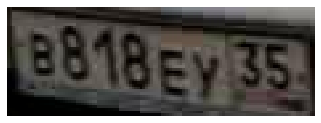

Rotated img:


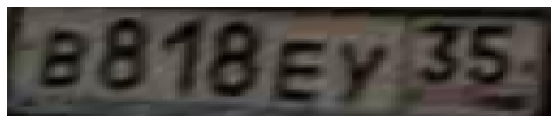

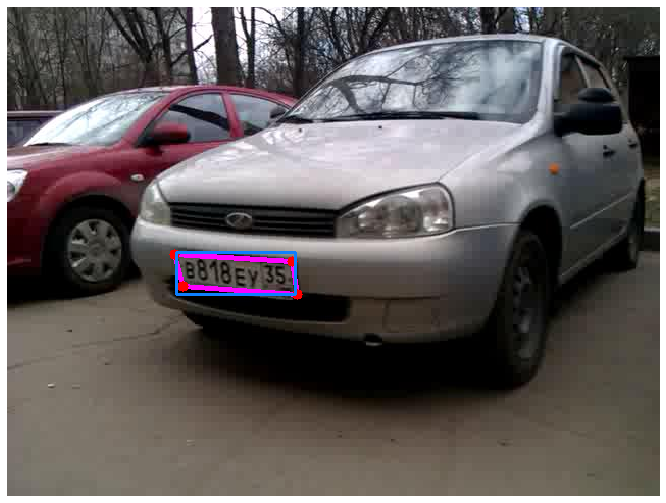

{'boxes': tensor([[166.6761, 241.6978, 282.7832, 282.8679]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9997], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}

In [11]:
visualize_prediction_plate(np.random.choice(test_images), model, id_to_name={1: 'plate'}, thresh=0.95)

### d) Предсказываем bounding box-ы и маску. 

- Маску превращаем в 4-угольный полигон. Сохраняем предсказания в json
- Если маска не приближается 4-угольником (редко такое бывает, бинарный поиск по гиперпараметру не работает), то просто записываем координаты bounding box 

In [12]:
from PIL import features
print (features.check_module('webp'))

THRESHOLD_SCORE = 0.93
TRESHOLD_MASK = 0.05


preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):

    if not features.check_module('webp') and '.webp' in file.lower():
        img = webp.load_image(file, 'RGBA').convert('RGB')
    else:
        img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE:            
            # В разных версиях opencv этот метод возвращает разное число параметров
            # contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

  0%|          | 0/3188 [00:00<?, ?it/s]

False


# 2. Распознаем номера

### a) Датасет для распознавания номеров

Из особенностей - на каждый номер мы генерируем bounding box + вырезаем по точкам и превращаем в прямоугольник наш 4-угольник по данным точкам. Т.е. 2 картинки на номер.

In [13]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

0

### b) Модель для распознования текста номера

Взял RCNN из семинара

In [14]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=False
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

### c) Обучаем модель для распознавания текста номера

In [15]:
crnn = CRNN()
# crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device);

In [16]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [17]:
# Здесь тоже оставил пока обучение без валидации. 
# Может, здесь и стоит валидировать. 
# Но опять же, 1-2 эпох хватает, а значит модель видит почти все данные 
# в первый раз и лосс на трейне вполне отражает реальность

crnn.train()
for epoch in range(2):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

  1%|          | 20/2913 [00:09<21:25,  2.25it/s]

Loss: 5.6629573


  1%|▏         | 40/2913 [00:18<21:06,  2.27it/s]

Loss: 3.7230242


  2%|▏         | 60/2913 [00:27<21:22,  2.23it/s]

Loss: 3.4533087


  3%|▎         | 80/2913 [00:35<19:10,  2.46it/s]

Loss: 3.3725808


  3%|▎         | 100/2913 [00:43<18:39,  2.51it/s]

Loss: 3.2951694


  4%|▍         | 120/2913 [00:52<23:31,  1.98it/s]

Loss: 3.2451970


  5%|▍         | 140/2913 [01:01<23:52,  1.94it/s]

Loss: 3.1987660


  5%|▌         | 160/2913 [01:09<19:23,  2.37it/s]

Loss: 3.0832074


  6%|▌         | 180/2913 [01:18<17:39,  2.58it/s]

Loss: 2.9948996


  7%|▋         | 200/2913 [01:25<16:02,  2.82it/s]

Loss: 2.9023624


  8%|▊         | 220/2913 [01:34<17:48,  2.52it/s]

Loss: 2.8334754


  8%|▊         | 240/2913 [01:43<18:06,  2.46it/s]

Loss: 2.7710050


  9%|▉         | 260/2913 [01:52<20:04,  2.20it/s]

Loss: 2.7304162


 10%|▉         | 280/2913 [02:00<20:28,  2.14it/s]

Loss: 2.6341976


 10%|█         | 300/2913 [02:09<19:39,  2.22it/s]

Loss: 2.5683083


 11%|█         | 320/2913 [02:19<21:23,  2.02it/s]

Loss: 2.4960843


 12%|█▏        | 340/2913 [02:29<22:33,  1.90it/s]

Loss: 2.4233134


 12%|█▏        | 360/2913 [02:39<19:55,  2.14it/s]

Loss: 2.3775353


 13%|█▎        | 380/2913 [02:49<15:45,  2.68it/s]

Loss: 2.2893948


 14%|█▎        | 400/2913 [03:00<33:45,  1.24it/s]

Loss: 2.2163177


 14%|█▍        | 420/2913 [03:12<26:11,  1.59it/s]

Loss: 2.1549425


 15%|█▌        | 440/2913 [03:21<18:20,  2.25it/s]

Loss: 2.0454756


 16%|█▌        | 460/2913 [03:31<18:41,  2.19it/s]

Loss: 1.9548245


 16%|█▋        | 480/2913 [03:42<22:25,  1.81it/s]

Loss: 1.8560264


 17%|█▋        | 500/2913 [03:50<13:37,  2.95it/s]

Loss: 1.7938926


 18%|█▊        | 520/2913 [03:58<17:17,  2.31it/s]

Loss: 1.6785715


 19%|█▊        | 540/2913 [04:08<24:38,  1.61it/s]

Loss: 1.5803012


 19%|█▉        | 560/2913 [04:19<16:37,  2.36it/s]

Loss: 1.5261448


 20%|█▉        | 580/2913 [04:28<23:05,  1.68it/s]

Loss: 1.4209646


 21%|██        | 600/2913 [04:38<17:05,  2.26it/s]

Loss: 1.3785205


 21%|██▏       | 620/2913 [04:49<20:07,  1.90it/s]

Loss: 1.3409273


 22%|██▏       | 640/2913 [05:01<16:17,  2.33it/s]

Loss: 1.3640678


 23%|██▎       | 660/2913 [05:10<17:06,  2.20it/s]

Loss: 1.2596939


 23%|██▎       | 680/2913 [05:21<17:13,  2.16it/s]

Loss: 1.2467362


 24%|██▍       | 700/2913 [05:31<15:09,  2.43it/s]

Loss: 1.2445081


 25%|██▍       | 720/2913 [05:41<20:29,  1.78it/s]

Loss: 1.2063903


 25%|██▌       | 740/2913 [05:51<16:38,  2.18it/s]

Loss: 1.1963850


 26%|██▌       | 760/2913 [06:03<27:21,  1.31it/s]

Loss: 1.1590192


 27%|██▋       | 780/2913 [06:18<22:42,  1.57it/s]

Loss: 1.1371105


 27%|██▋       | 800/2913 [06:32<27:08,  1.30it/s]

Loss: 1.1486510


 28%|██▊       | 820/2913 [06:46<27:23,  1.27it/s]

Loss: 1.1671458


 29%|██▉       | 840/2913 [07:03<28:42,  1.20it/s]

Loss: 1.1453245


 30%|██▉       | 860/2913 [07:20<33:58,  1.01it/s]

Loss: 1.1580909


 30%|███       | 880/2913 [07:44<29:00,  1.17it/s]  

Loss: 1.1097094


 31%|███       | 900/2913 [08:05<43:02,  1.28s/it]

Loss: 1.0798686


 32%|███▏      | 920/2913 [08:22<28:36,  1.16it/s]

Loss: 1.1362295


 32%|███▏      | 940/2913 [08:40<21:36,  1.52it/s]

Loss: 1.0741771


 33%|███▎      | 960/2913 [08:54<20:57,  1.55it/s]

Loss: 1.0686898


 34%|███▎      | 980/2913 [09:07<27:20,  1.18it/s]

Loss: 1.0647327


 34%|███▍      | 1000/2913 [09:23<27:04,  1.18it/s]

Loss: 1.0562083


 35%|███▌      | 1020/2913 [09:39<25:30,  1.24it/s]

Loss: 0.9901052


 36%|███▌      | 1040/2913 [09:50<14:36,  2.14it/s]

Loss: 1.0123378


 36%|███▋      | 1060/2913 [09:59<12:52,  2.40it/s]

Loss: 1.0160724


 37%|███▋      | 1080/2913 [10:06<11:48,  2.59it/s]

Loss: 1.0019727


 38%|███▊      | 1100/2913 [10:17<26:26,  1.14it/s]

Loss: 1.0054295


 38%|███▊      | 1120/2913 [10:27<17:01,  1.76it/s]

Loss: 0.9943918


 39%|███▉      | 1140/2913 [10:36<13:51,  2.13it/s]

Loss: 0.9790342


 40%|███▉      | 1160/2913 [10:46<11:14,  2.60it/s]

Loss: 0.9602538


 41%|████      | 1180/2913 [10:55<13:57,  2.07it/s]

Loss: 0.9455585


 41%|████      | 1200/2913 [11:04<11:08,  2.56it/s]

Loss: 0.9431631


 42%|████▏     | 1220/2913 [11:13<12:19,  2.29it/s]

Loss: 0.9186542


 43%|████▎     | 1240/2913 [11:22<11:38,  2.39it/s]

Loss: 0.8956936


 43%|████▎     | 1260/2913 [11:30<09:59,  2.76it/s]

Loss: 0.8005810


 44%|████▍     | 1280/2913 [11:39<13:17,  2.05it/s]

Loss: 0.8347645


 45%|████▍     | 1300/2913 [11:47<13:30,  1.99it/s]

Loss: 0.8395646


 45%|████▌     | 1320/2913 [11:57<13:45,  1.93it/s]

Loss: 0.8333383


 46%|████▌     | 1340/2913 [12:08<15:37,  1.68it/s]

Loss: 0.7985363


 47%|████▋     | 1360/2913 [12:16<11:45,  2.20it/s]

Loss: 0.8229059


 47%|████▋     | 1380/2913 [12:26<14:23,  1.77it/s]

Loss: 0.8020129


 48%|████▊     | 1400/2913 [12:37<15:26,  1.63it/s]

Loss: 0.7625596


 49%|████▊     | 1420/2913 [12:46<12:16,  2.03it/s]

Loss: 0.8134502


 49%|████▉     | 1440/2913 [12:55<11:11,  2.19it/s]

Loss: 0.8081722


 50%|█████     | 1460/2913 [13:04<13:34,  1.78it/s]

Loss: 0.7567256


 51%|█████     | 1480/2913 [13:12<10:02,  2.38it/s]

Loss: 0.7679362


 51%|█████▏    | 1500/2913 [13:23<16:06,  1.46it/s]

Loss: 0.7153230


 52%|█████▏    | 1520/2913 [13:38<15:26,  1.50it/s]

Loss: 0.7128372


 53%|█████▎    | 1540/2913 [13:52<12:09,  1.88it/s]

Loss: 0.7244009


 54%|█████▎    | 1560/2913 [14:01<09:48,  2.30it/s]

Loss: 0.7081533


 54%|█████▍    | 1580/2913 [14:10<08:19,  2.67it/s]

Loss: 0.7154546


 55%|█████▍    | 1600/2913 [14:19<10:24,  2.10it/s]

Loss: 0.6872587


 56%|█████▌    | 1620/2913 [14:28<08:45,  2.46it/s]

Loss: 0.6511821


 56%|█████▋    | 1640/2913 [14:36<09:38,  2.20it/s]

Loss: 0.6536233


 57%|█████▋    | 1660/2913 [14:48<11:09,  1.87it/s]

Loss: 0.6442052


 58%|█████▊    | 1680/2913 [14:59<08:00,  2.56it/s]

Loss: 0.6375527


 58%|█████▊    | 1700/2913 [15:08<09:41,  2.09it/s]

Loss: 0.6226493


 59%|█████▉    | 1720/2913 [15:28<18:39,  1.07it/s]

Loss: 0.6448851


 60%|█████▉    | 1740/2913 [15:42<10:23,  1.88it/s]

Loss: 0.6350393


 60%|██████    | 1760/2913 [15:50<07:34,  2.54it/s]

Loss: 0.6107437


 61%|██████    | 1780/2913 [16:00<09:15,  2.04it/s]

Loss: 0.6094042


 62%|██████▏   | 1800/2913 [16:11<08:00,  2.32it/s]

Loss: 0.5984508


 62%|██████▏   | 1820/2913 [16:21<10:34,  1.72it/s]

Loss: 0.6136067


 63%|██████▎   | 1840/2913 [16:30<07:47,  2.29it/s]

Loss: 0.6340896


 64%|██████▍   | 1860/2913 [16:38<06:57,  2.52it/s]

Loss: 0.5764371


 65%|██████▍   | 1880/2913 [16:46<06:25,  2.68it/s]

Loss: 0.6314405


 65%|██████▌   | 1900/2913 [16:55<07:11,  2.35it/s]

Loss: 0.5799486


 66%|██████▌   | 1920/2913 [17:03<06:40,  2.48it/s]

Loss: 0.5671576


 67%|██████▋   | 1940/2913 [17:12<08:22,  1.94it/s]

Loss: 0.5453323


 67%|██████▋   | 1960/2913 [17:21<06:22,  2.49it/s]

Loss: 0.5523786


 68%|██████▊   | 1980/2913 [17:29<07:29,  2.08it/s]

Loss: 0.4976238


 69%|██████▊   | 2000/2913 [17:38<05:42,  2.67it/s]

Loss: 0.5097062


 69%|██████▉   | 2020/2913 [17:49<07:17,  2.04it/s]

Loss: 0.4519341


 70%|███████   | 2040/2913 [18:01<06:56,  2.10it/s]

Loss: 0.4606506


 71%|███████   | 2060/2913 [18:08<05:09,  2.76it/s]

Loss: 0.5138109


 71%|███████▏  | 2080/2913 [18:17<05:56,  2.34it/s]

Loss: 0.3917670


 72%|███████▏  | 2100/2913 [18:25<05:46,  2.34it/s]

Loss: 0.4665859


 73%|███████▎  | 2120/2913 [18:34<05:41,  2.32it/s]

Loss: 0.4282405


 73%|███████▎  | 2140/2913 [18:45<06:20,  2.03it/s]

Loss: 0.4377706


 74%|███████▍  | 2160/2913 [18:55<06:38,  1.89it/s]

Loss: 0.3963692


 75%|███████▍  | 2180/2913 [19:05<06:04,  2.01it/s]

Loss: 0.4119482


 76%|███████▌  | 2200/2913 [19:17<05:38,  2.10it/s]

Loss: 0.3833323


 76%|███████▌  | 2220/2913 [19:26<05:08,  2.25it/s]

Loss: 0.3366433


 77%|███████▋  | 2240/2913 [19:35<05:09,  2.18it/s]

Loss: 0.3874106


 78%|███████▊  | 2260/2913 [19:43<04:21,  2.50it/s]

Loss: 0.3717550


 78%|███████▊  | 2280/2913 [19:51<04:34,  2.31it/s]

Loss: 0.3667231


 79%|███████▉  | 2300/2913 [20:00<03:49,  2.67it/s]

Loss: 0.3454924


 80%|███████▉  | 2320/2913 [20:08<03:44,  2.64it/s]

Loss: 0.3248440


 80%|████████  | 2340/2913 [20:17<04:07,  2.32it/s]

Loss: 0.3541770


 81%|████████  | 2360/2913 [20:25<03:11,  2.89it/s]

Loss: 0.3450061


 82%|████████▏ | 2380/2913 [20:33<04:10,  2.13it/s]

Loss: 0.3485406


 82%|████████▏ | 2400/2913 [20:41<03:39,  2.34it/s]

Loss: 0.2843296


 83%|████████▎ | 2420/2913 [20:50<03:37,  2.27it/s]

Loss: 0.3022061


 84%|████████▍ | 2440/2913 [21:00<03:39,  2.15it/s]

Loss: 0.2892535


 84%|████████▍ | 2460/2913 [21:08<02:53,  2.61it/s]

Loss: 0.3040959


 85%|████████▌ | 2480/2913 [21:16<03:05,  2.34it/s]

Loss: 0.3287181


 86%|████████▌ | 2500/2913 [21:24<03:04,  2.24it/s]

Loss: 0.2875660


 87%|████████▋ | 2520/2913 [21:33<02:54,  2.26it/s]

Loss: 0.3359451


 87%|████████▋ | 2540/2913 [21:42<02:41,  2.31it/s]

Loss: 0.2931815


 88%|████████▊ | 2560/2913 [21:50<02:03,  2.86it/s]

Loss: 0.3040701


 89%|████████▊ | 2580/2913 [21:58<02:21,  2.35it/s]

Loss: 0.2918427


 89%|████████▉ | 2600/2913 [22:07<02:36,  2.00it/s]

Loss: 0.2826567


 90%|████████▉ | 2620/2913 [22:15<01:45,  2.78it/s]

Loss: 0.2391401


 91%|█████████ | 2640/2913 [22:25<01:54,  2.38it/s]

Loss: 0.2628469


 91%|█████████▏| 2660/2913 [22:34<01:48,  2.32it/s]

Loss: 0.2931103


 92%|█████████▏| 2680/2913 [22:43<02:04,  1.87it/s]

Loss: 0.2831646


 93%|█████████▎| 2700/2913 [22:52<01:40,  2.11it/s]

Loss: 0.2390518


 93%|█████████▎| 2720/2913 [23:00<01:22,  2.34it/s]

Loss: 0.2565219


 94%|█████████▍| 2740/2913 [23:08<01:11,  2.42it/s]

Loss: 0.2430335


 95%|█████████▍| 2760/2913 [23:16<01:07,  2.27it/s]

Loss: 0.2402236


 95%|█████████▌| 2780/2913 [23:24<00:55,  2.39it/s]

Loss: 0.2435979


 96%|█████████▌| 2800/2913 [23:33<00:41,  2.75it/s]

Loss: 0.2576656


 97%|█████████▋| 2820/2913 [23:41<00:36,  2.52it/s]

Loss: 0.2444563


 97%|█████████▋| 2840/2913 [23:50<00:30,  2.39it/s]

Loss: 0.2180718


 98%|█████████▊| 2860/2913 [23:58<00:19,  2.74it/s]

Loss: 0.2759644


 99%|█████████▉| 2880/2913 [24:07<00:14,  2.28it/s]

Loss: 0.2219102


100%|█████████▉| 2900/2913 [24:14<00:05,  2.45it/s]

Loss: 0.2178094


  0%|          | 0/2913 [00:00<?, ?it/s]           

2912 1.0527535516792992


  1%|          | 20/2913 [00:08<19:52,  2.43it/s]

Loss: 0.2025022


  1%|▏         | 40/2913 [00:16<22:25,  2.14it/s]

Loss: 0.2181526


  2%|▏         | 60/2913 [00:24<18:53,  2.52it/s]

Loss: 0.1805194


  3%|▎         | 80/2913 [00:34<19:40,  2.40it/s]

Loss: 0.2460386


  3%|▎         | 100/2913 [00:43<19:39,  2.38it/s]

Loss: 0.2205419


  4%|▍         | 120/2913 [00:52<19:31,  2.38it/s]

Loss: 0.2128153


  5%|▍         | 140/2913 [01:00<17:27,  2.65it/s]

Loss: 0.2300136


  5%|▌         | 160/2913 [01:09<17:28,  2.62it/s]

Loss: 0.2005414


  6%|▌         | 180/2913 [01:17<17:28,  2.61it/s]

Loss: 0.2451462


  7%|▋         | 200/2913 [01:25<17:02,  2.65it/s]

Loss: 0.2033378


  8%|▊         | 220/2913 [01:33<18:48,  2.39it/s]

Loss: 0.1994583


  8%|▊         | 240/2913 [01:41<16:30,  2.70it/s]

Loss: 0.1919789


  9%|▉         | 260/2913 [01:49<17:04,  2.59it/s]

Loss: 0.2356215


 10%|▉         | 280/2913 [01:57<18:14,  2.41it/s]

Loss: 0.1930539
Epoch   159: reducing learning rate of group 0 to 1.5000e-04.


 10%|█         | 300/2913 [02:05<16:26,  2.65it/s]

Loss: 0.2670838


 11%|█         | 320/2913 [02:14<17:47,  2.43it/s]

Loss: 0.2361026


 12%|█▏        | 340/2913 [02:22<20:09,  2.13it/s]

Loss: 0.2013157


 12%|█▏        | 360/2913 [02:31<22:28,  1.89it/s]

Loss: 0.1987189


 13%|█▎        | 380/2913 [02:38<13:05,  3.23it/s]

Loss: 0.1987335


 14%|█▎        | 400/2913 [02:47<19:09,  2.19it/s]

Loss: 0.1532350


 14%|█▍        | 420/2913 [02:55<17:11,  2.42it/s]

Loss: 0.1798280


 15%|█▌        | 440/2913 [03:03<15:14,  2.70it/s]

Loss: 0.1764702


 16%|█▌        | 460/2913 [03:12<16:36,  2.46it/s]

Loss: 0.2062359


 16%|█▋        | 480/2913 [03:21<18:04,  2.24it/s]

Loss: 0.1719988


 17%|█▋        | 500/2913 [03:29<15:30,  2.59it/s]

Loss: 0.1947107


 18%|█▊        | 520/2913 [03:37<17:13,  2.32it/s]

Loss: 0.1948996


 19%|█▊        | 540/2913 [03:45<16:08,  2.45it/s]

Loss: 0.1702141


 19%|█▉        | 560/2913 [03:53<15:57,  2.46it/s]

Loss: 0.1633746


 20%|█▉        | 580/2913 [04:02<17:48,  2.18it/s]

Loss: 0.2008942


 21%|██        | 600/2913 [04:10<18:10,  2.12it/s]

Loss: 0.1505899


 21%|██▏       | 620/2913 [04:18<15:02,  2.54it/s]

Loss: 0.1374650


 22%|██▏       | 640/2913 [04:26<16:42,  2.27it/s]

Loss: 0.1845770


 23%|██▎       | 660/2913 [04:34<18:03,  2.08it/s]

Loss: 0.1361598


 23%|██▎       | 680/2913 [04:43<14:02,  2.65it/s]

Loss: 0.1493501


 24%|██▍       | 700/2913 [04:51<18:10,  2.03it/s]

Loss: 0.1677484


 25%|██▍       | 720/2913 [04:59<12:49,  2.85it/s]

Loss: 0.1702660


 25%|██▌       | 740/2913 [05:08<14:58,  2.42it/s]

Loss: 0.1815981


 26%|██▌       | 760/2913 [05:16<16:34,  2.17it/s]

Loss: 0.1167838


 27%|██▋       | 780/2913 [05:24<11:43,  3.03it/s]

Loss: 0.1417049


 27%|██▋       | 800/2913 [05:33<14:00,  2.51it/s]

Loss: 0.1895522


 28%|██▊       | 820/2913 [05:41<15:38,  2.23it/s]

Loss: 0.1325978


 29%|██▉       | 840/2913 [05:50<13:14,  2.61it/s]

Loss: 0.1360062


 30%|██▉       | 860/2913 [05:59<16:15,  2.10it/s]

Loss: 0.1358129


 30%|███       | 880/2913 [06:07<12:24,  2.73it/s]

Loss: 0.1381961


 31%|███       | 900/2913 [06:14<11:34,  2.90it/s]

Loss: 0.1706694


 32%|███▏      | 920/2913 [06:22<12:29,  2.66it/s]

Loss: 0.1814083


 32%|███▏      | 940/2913 [06:30<14:20,  2.29it/s]

Loss: 0.1422354


 33%|███▎      | 960/2913 [06:38<11:53,  2.74it/s]

Loss: 0.1841035


 34%|███▎      | 980/2913 [06:47<13:36,  2.37it/s]

Loss: 0.1576097
Epoch   194: reducing learning rate of group 0 to 7.5000e-05.


 34%|███▍      | 1000/2913 [06:55<11:18,  2.82it/s]

Loss: 0.1595585


 35%|███▌      | 1020/2913 [07:03<14:44,  2.14it/s]

Loss: 0.1341729


 36%|███▌      | 1040/2913 [07:13<15:10,  2.06it/s]

Loss: 0.1842166


 36%|███▋      | 1060/2913 [07:21<11:28,  2.69it/s]

Loss: 0.1385127


 37%|███▋      | 1080/2913 [07:29<12:08,  2.52it/s]

Loss: 0.1618153


 38%|███▊      | 1100/2913 [07:38<13:54,  2.17it/s]

Loss: 0.1472057


 38%|███▊      | 1120/2913 [07:45<12:20,  2.42it/s]

Loss: 0.1613570


 39%|███▉      | 1140/2913 [07:53<12:29,  2.37it/s]

Loss: 0.1379311


 40%|███▉      | 1160/2913 [08:00<11:25,  2.56it/s]

Loss: 0.1817318


 41%|████      | 1180/2913 [08:08<11:27,  2.52it/s]

Loss: 0.1561899


 41%|████      | 1200/2913 [08:16<10:57,  2.61it/s]

Loss: 0.1709996
Epoch   205: reducing learning rate of group 0 to 3.7500e-05.


 42%|████▏     | 1220/2913 [08:23<10:16,  2.75it/s]

Loss: 0.1393459


 43%|████▎     | 1240/2913 [08:31<13:18,  2.09it/s]

Loss: 0.1735542


 43%|████▎     | 1260/2913 [08:39<11:09,  2.47it/s]

Loss: 0.1401411


 44%|████▍     | 1280/2913 [08:48<12:20,  2.20it/s]

Loss: 0.1629074


 45%|████▍     | 1300/2913 [08:57<12:25,  2.16it/s]

Loss: 0.1502739


 45%|████▌     | 1320/2913 [09:04<10:14,  2.59it/s]

Loss: 0.1357405


 46%|████▌     | 1340/2913 [09:12<08:39,  3.03it/s]

Loss: 0.1227650


 47%|████▋     | 1360/2913 [09:20<12:19,  2.10it/s]

Loss: 0.1385469


 47%|████▋     | 1380/2913 [09:29<11:01,  2.32it/s]

Loss: 0.1343386


 48%|████▊     | 1400/2913 [09:37<12:17,  2.05it/s]

Loss: 0.1517518


 49%|████▊     | 1420/2913 [09:46<09:27,  2.63it/s]

Loss: 0.1203137
Epoch   216: reducing learning rate of group 0 to 1.8750e-05.


 49%|████▉     | 1440/2913 [09:55<09:28,  2.59it/s]

Loss: 0.1431146


 50%|█████     | 1460/2913 [10:03<10:13,  2.37it/s]

Loss: 0.1583092


 51%|█████     | 1480/2913 [10:12<11:05,  2.15it/s]

Loss: 0.1530446


 51%|█████▏    | 1500/2913 [10:21<09:22,  2.51it/s]

Loss: 0.1455640


 52%|█████▏    | 1520/2913 [10:28<08:34,  2.71it/s]

Loss: 0.1156106


 53%|█████▎    | 1540/2913 [10:36<08:35,  2.66it/s]

Loss: 0.1566969


 54%|█████▎    | 1560/2913 [10:44<08:44,  2.58it/s]

Loss: 0.1385558


 54%|█████▍    | 1580/2913 [10:52<08:38,  2.57it/s]

Loss: 0.1540923


 55%|█████▍    | 1600/2913 [11:01<09:11,  2.38it/s]

Loss: 0.1424216


 56%|█████▌    | 1620/2913 [11:09<08:35,  2.51it/s]

Loss: 0.1332198


 56%|█████▋    | 1640/2913 [11:17<07:58,  2.66it/s]

Loss: 0.1344589


 57%|█████▋    | 1660/2913 [11:26<08:44,  2.39it/s]

Loss: 0.1194249


 58%|█████▊    | 1680/2913 [11:35<09:36,  2.14it/s]

Loss: 0.1358854


 58%|█████▊    | 1700/2913 [11:44<08:52,  2.28it/s]

Loss: 0.1851787


 59%|█████▉    | 1720/2913 [11:51<07:12,  2.76it/s]

Loss: 0.1437614


 60%|█████▉    | 1740/2913 [12:00<07:23,  2.64it/s]

Loss: 0.1314538
Epoch   232: reducing learning rate of group 0 to 9.3750e-06.


 60%|██████    | 1760/2913 [12:08<08:33,  2.24it/s]

Loss: 0.0993828


 61%|██████    | 1780/2913 [12:17<08:38,  2.19it/s]

Loss: 0.1749084


 62%|██████▏   | 1800/2913 [12:25<07:38,  2.43it/s]

Loss: 0.1368344


 62%|██████▏   | 1820/2913 [12:34<06:51,  2.66it/s]

Loss: 0.1594568


 63%|██████▎   | 1840/2913 [12:42<08:15,  2.17it/s]

Loss: 0.1435688


 64%|██████▍   | 1860/2913 [12:50<07:19,  2.40it/s]

Loss: 0.1835593


 65%|██████▍   | 1880/2913 [12:59<07:14,  2.38it/s]

Loss: 0.1486335


 65%|██████▌   | 1900/2913 [13:08<07:55,  2.13it/s]

Loss: 0.1713557


 66%|██████▌   | 1920/2913 [13:17<08:24,  1.97it/s]

Loss: 0.1231210


 67%|██████▋   | 1940/2913 [13:25<06:26,  2.52it/s]

Loss: 0.1566392


 67%|██████▋   | 1960/2913 [13:33<06:01,  2.63it/s]

Loss: 0.1553638


 68%|██████▊   | 1980/2913 [13:41<06:54,  2.25it/s]

Loss: 0.1340957
Epoch   244: reducing learning rate of group 0 to 4.6875e-06.


 69%|██████▊   | 2000/2913 [13:49<06:45,  2.25it/s]

Loss: 0.1789412


 69%|██████▉   | 2020/2913 [13:58<06:19,  2.35it/s]

Loss: 0.1521602


 70%|███████   | 2040/2913 [14:07<06:38,  2.19it/s]

Loss: 0.1154820


 71%|███████   | 2060/2913 [14:16<06:16,  2.26it/s]

Loss: 0.1580529


 71%|███████▏  | 2080/2913 [14:25<05:59,  2.32it/s]

Loss: 0.1264718


 72%|███████▏  | 2100/2913 [14:34<05:45,  2.35it/s]

Loss: 0.1288173


 73%|███████▎  | 2120/2913 [14:41<05:45,  2.30it/s]

Loss: 0.1313206


 73%|███████▎  | 2140/2913 [14:50<05:01,  2.56it/s]

Loss: 0.1088830


 74%|███████▍  | 2160/2913 [14:58<04:44,  2.65it/s]

Loss: 0.1556192


 75%|███████▍  | 2180/2913 [15:06<04:48,  2.54it/s]

Loss: 0.1520898


 76%|███████▌  | 2200/2913 [15:14<05:05,  2.34it/s]

Loss: 0.1354823
Epoch   255: reducing learning rate of group 0 to 2.3437e-06.


 76%|███████▌  | 2220/2913 [15:22<04:49,  2.39it/s]

Loss: 0.1354728


 77%|███████▋  | 2240/2913 [15:30<03:53,  2.88it/s]

Loss: 0.1799866


 78%|███████▊  | 2260/2913 [15:37<04:20,  2.50it/s]

Loss: 0.1314211


 78%|███████▊  | 2280/2913 [15:45<04:12,  2.51it/s]

Loss: 0.1348989


 79%|███████▉  | 2300/2913 [15:54<04:23,  2.33it/s]

Loss: 0.2252805


 80%|███████▉  | 2320/2913 [16:02<03:42,  2.66it/s]

Loss: 0.1380502


 80%|████████  | 2340/2913 [16:10<03:34,  2.67it/s]

Loss: 0.1307851


 81%|████████  | 2360/2913 [16:18<03:37,  2.54it/s]

Loss: 0.1484474


 82%|████████▏ | 2380/2913 [16:26<03:43,  2.38it/s]

Loss: 0.1623274


 82%|████████▏ | 2400/2913 [16:34<03:13,  2.65it/s]

Loss: 0.1595761


 83%|████████▎ | 2420/2913 [16:42<03:16,  2.51it/s]

Loss: 0.1599815
Epoch   266: reducing learning rate of group 0 to 1.1719e-06.


 84%|████████▍ | 2440/2913 [16:50<03:18,  2.38it/s]

Loss: 0.1308082


 84%|████████▍ | 2460/2913 [16:58<03:10,  2.37it/s]

Loss: 0.1702551


 85%|████████▌ | 2480/2913 [17:06<03:22,  2.13it/s]

Loss: 0.1689434


 86%|████████▌ | 2500/2913 [17:14<02:36,  2.64it/s]

Loss: 0.1491397


 87%|████████▋ | 2520/2913 [17:22<02:32,  2.58it/s]

Loss: 0.1079285


 87%|████████▋ | 2540/2913 [17:31<02:39,  2.34it/s]

Loss: 0.1800984


 88%|████████▊ | 2560/2913 [17:39<02:38,  2.23it/s]

Loss: 0.1650789


 89%|████████▊ | 2580/2913 [17:48<02:26,  2.27it/s]

Loss: 0.1067916


 89%|████████▉ | 2600/2913 [17:56<02:03,  2.54it/s]

Loss: 0.0991447


 90%|████████▉ | 2620/2913 [18:04<01:58,  2.48it/s]

Loss: 0.1713524


 91%|█████████ | 2640/2913 [18:12<01:46,  2.55it/s]

Loss: 0.1601465


 91%|█████████▏| 2660/2913 [18:20<01:38,  2.57it/s]

Loss: 0.1629034


 92%|█████████▏| 2680/2913 [18:28<01:26,  2.68it/s]

Loss: 0.1165450


 93%|█████████▎| 2700/2913 [18:37<01:28,  2.42it/s]

Loss: 0.1303756


 93%|█████████▎| 2720/2913 [18:45<01:24,  2.29it/s]

Loss: 0.1575793


 94%|█████████▍| 2740/2913 [18:53<01:08,  2.54it/s]

Loss: 0.1226374


 95%|█████████▍| 2760/2913 [19:01<01:05,  2.35it/s]

Loss: 0.1384629


 95%|█████████▌| 2780/2913 [19:09<00:57,  2.32it/s]

Loss: 0.1605263


 96%|█████████▌| 2800/2913 [19:18<00:55,  2.05it/s]

Loss: 0.1418382


 97%|█████████▋| 2820/2913 [19:26<00:40,  2.32it/s]

Loss: 0.1595474
Epoch   286: reducing learning rate of group 0 to 5.8594e-07.


 97%|█████████▋| 2840/2913 [19:35<00:34,  2.13it/s]

Loss: 0.1572024


 98%|█████████▊| 2860/2913 [19:45<00:25,  2.07it/s]

Loss: 0.1315054


 99%|█████████▉| 2880/2913 [19:54<00:15,  2.14it/s]

Loss: 0.1276096


100%|█████████▉| 2900/2913 [20:03<00:06,  2.07it/s]

Loss: 0.1701943


2912 0.1593749262929638


In [18]:
torch.save(crnn.state_dict(), OCR_MODEL_PATH)

### d) Наконец, делаем предсказания

In [19]:
test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submission.csv', index=False)

Как-то так :)

In [20]:
!head submission.csv

file_name,plates_string
test/1062.jpg,H900OC72
test/2231.jpg,M440YH72
test/2688.jpg,M202OM97
test/877.bmp,A138TC35
test/2592.jpg,M770OB44
test/1875.jpg,P012CB12
test/671.jpg,T768OE54
test/1739.jpg,
test/2276.jpg,H888AX197


In [21]:
df_submit[df_submit.plates_string == ""]

,file_name,plates_string
7,test/1739.jpg,
29,test/1500.jpg,
94,test/791.jpg,
182,test/2926.jpg,
236,test/1087.bmp,
240,test/2303.jpg,
296,test/546.jpg,
457,test/2249.jpg,
819,test/2972.jpg,
867,test/1143.jpg,


In [27]:
from PIL import Image
im = Image.open('./data/test/166.jpg')
im.show()